# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types
import math
import lightgbm

from lightgbm import LGBMClassifier, LGBMRegressor
from scipy.stats import zscore, randint, uniform, loguniform, mode
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, OrdinalEncoder, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    ConfusionMatrixDisplay, average_precision_score,
    balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
    log_loss, jaccard_score, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score, silhouette_score,
    davies_bouldin_score
)
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, XGBRegressor
#from lifelines.utils import concordance_index
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import randint, uniform, loguniform
from sklearn.decomposition import PCA

# **Load Dataset**

In [2]:
train_df = pd.read_csv('data/dataset_med.csv')
train_df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [3]:
print("Dataset Information")
print(train_df.info())

Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  890000 non-null  int64  
 1   age                 890000 non-null  float64
 2   gender              890000 non-null  object 
 3   country             890000 non-null  object 
 4   diagnosis_date      890000 non-null  object 
 5   cancer_stage        890000 non-null  object 
 6   family_history      890000 non-null  object 
 7   smoking_status      890000 non-null  object 
 8   bmi                 890000 non-null  float64
 9   cholesterol_level   890000 non-null  int64  
 10  hypertension        890000 non-null  int64  
 11  asthma              890000 non-null  int64  
 12  cirrhosis           890000 non-null  int64  
 13  other_cancer        890000 non-null  int64  
 14  treatment_type      890000 non-null  object 
 15  end_treatment_

# **Exploratory Data Analysis**

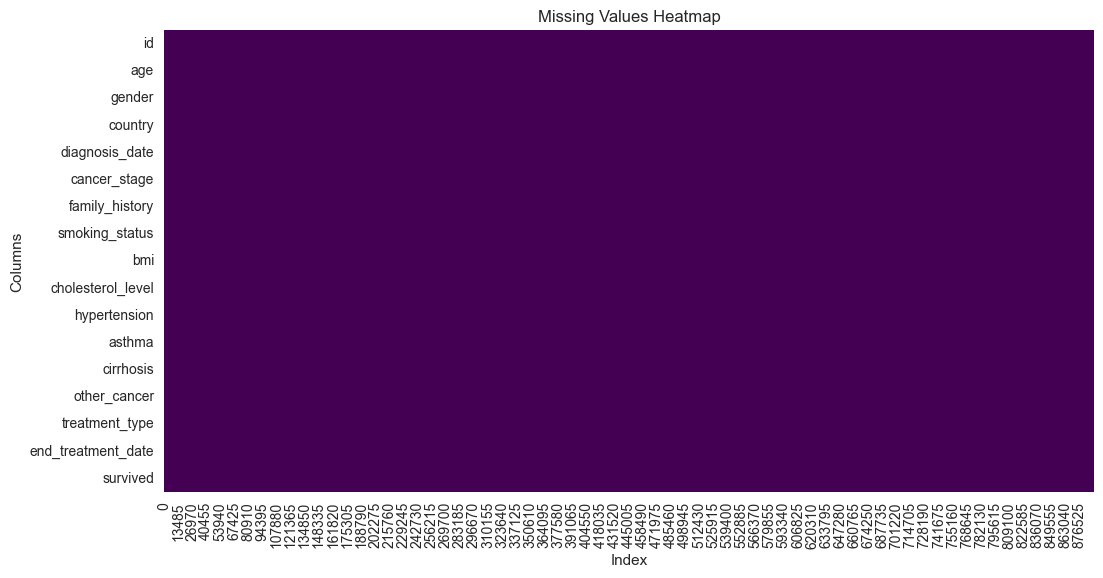

In [4]:
train_df_transposed = train_df.T

plt.figure(figsize=(12, 6))
sns.heatmap(train_df_transposed.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.xlabel("Index")
plt.ylabel("Columns")
plt.show()

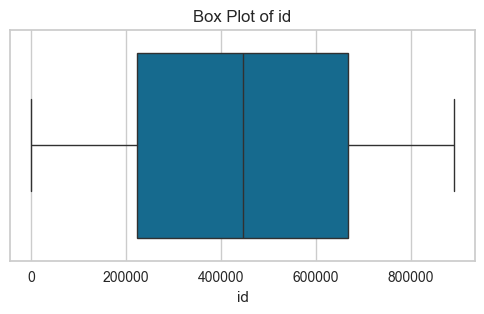

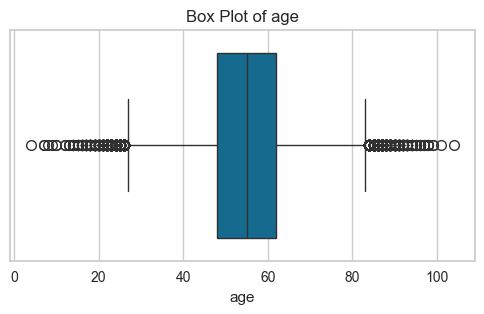

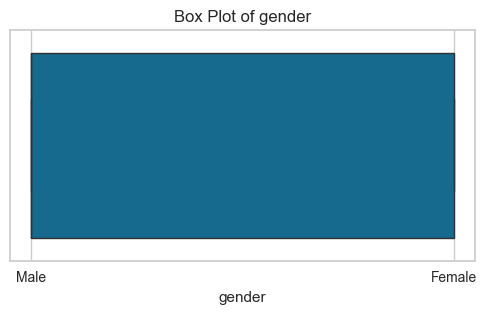

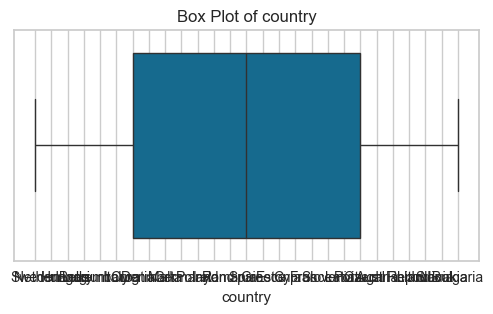

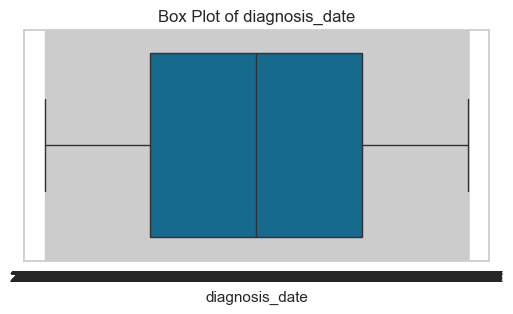

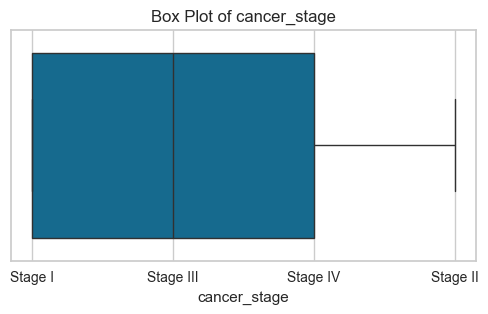

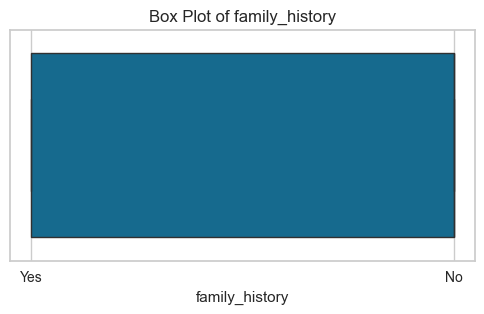

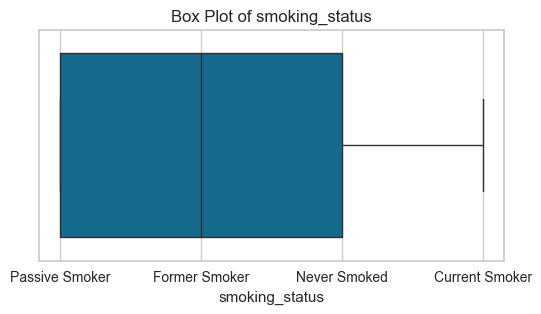

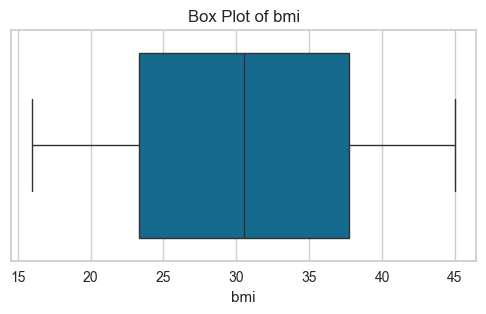

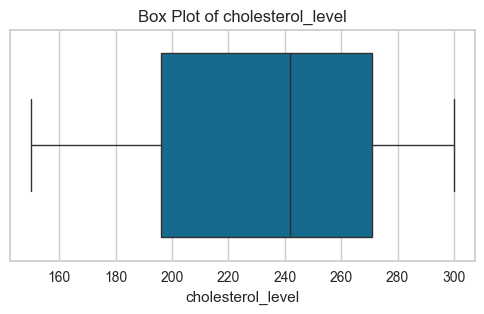

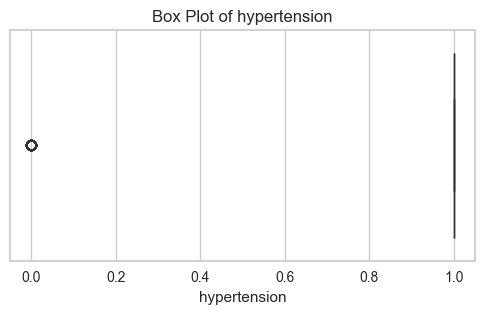

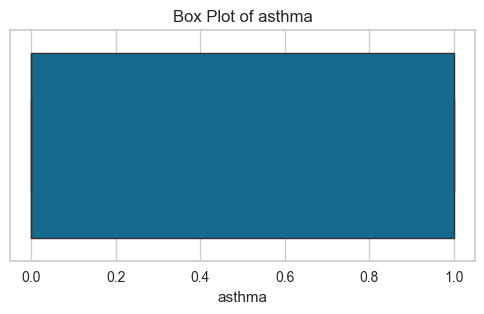

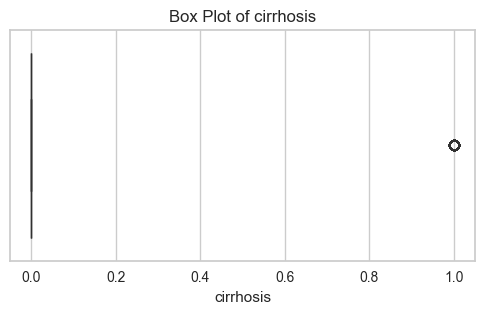

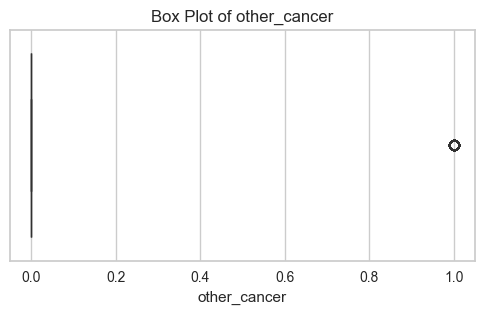

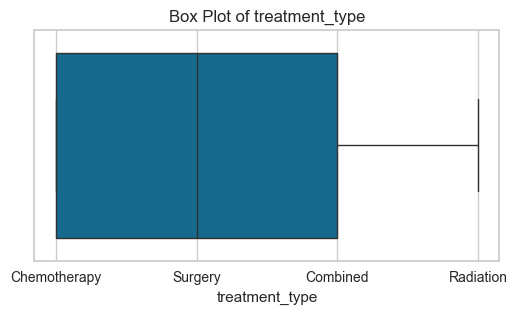

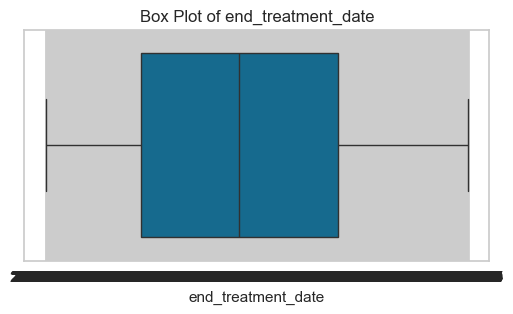

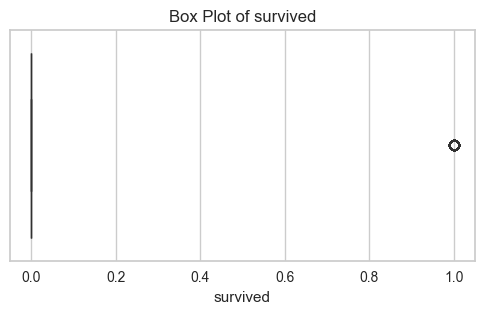

In [5]:
for feature in train_df.columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x = train_df[feature])
    plt.title(f"Box Plot of {feature}")
    plt.show()

In [5]:
num_col = train_df.select_dtypes(include=[np.number])
cat_col = train_df.select_dtypes(include=[object])

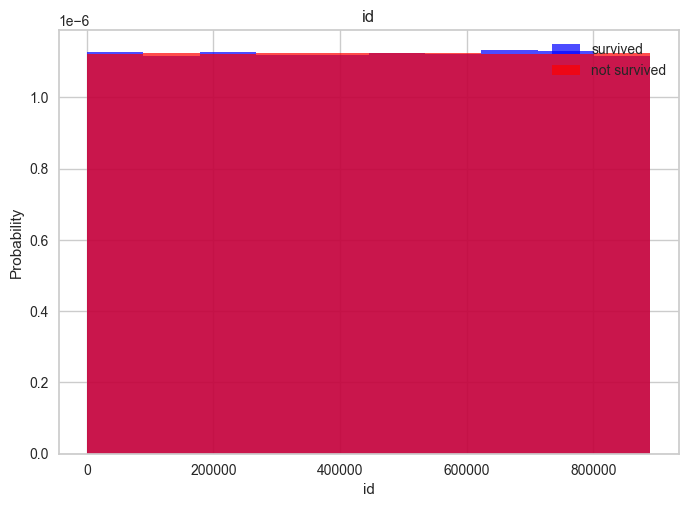

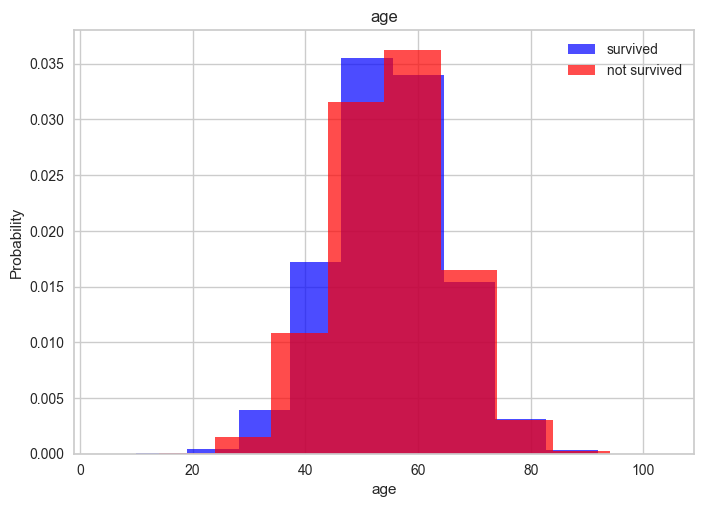

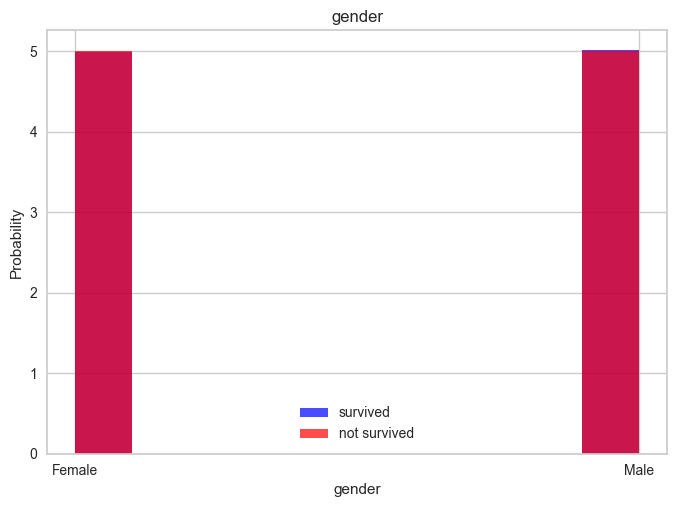

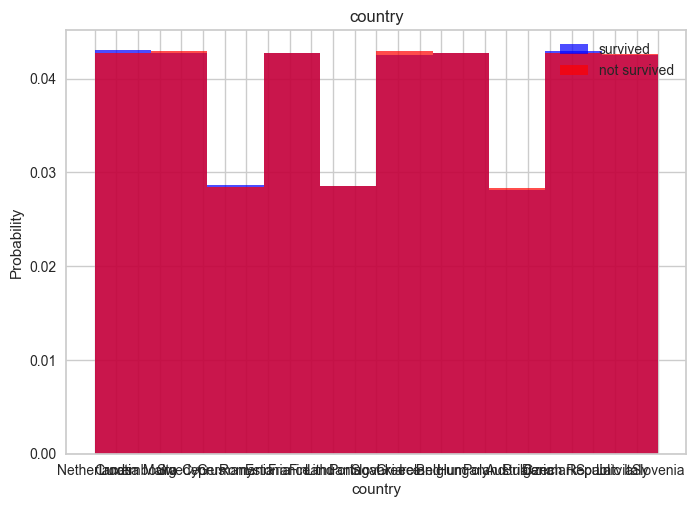

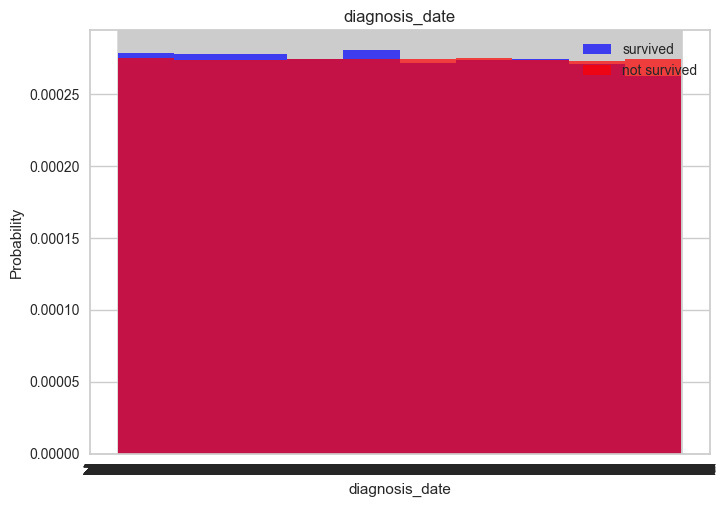

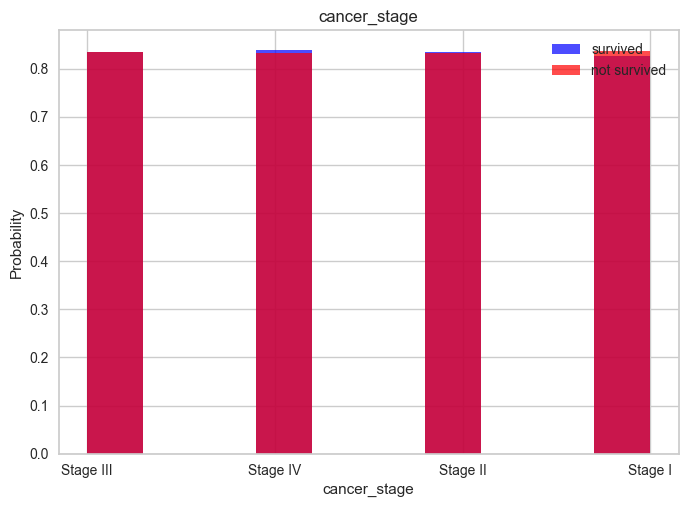

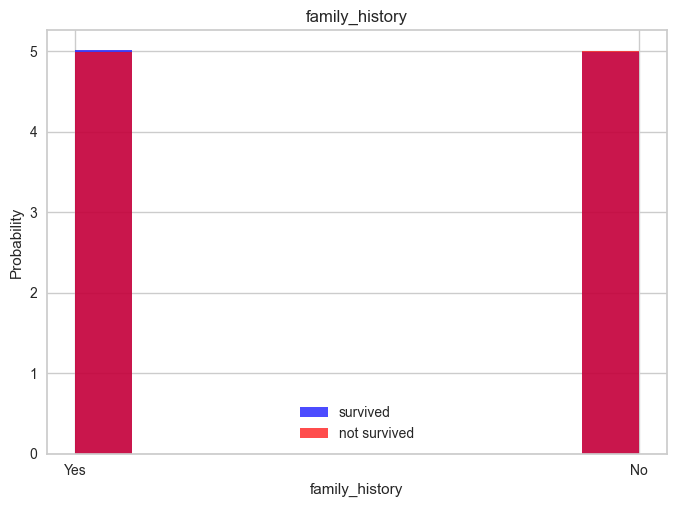

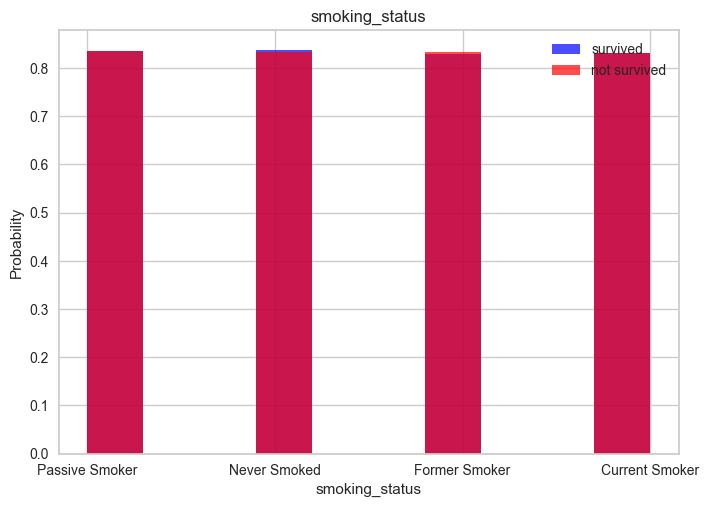

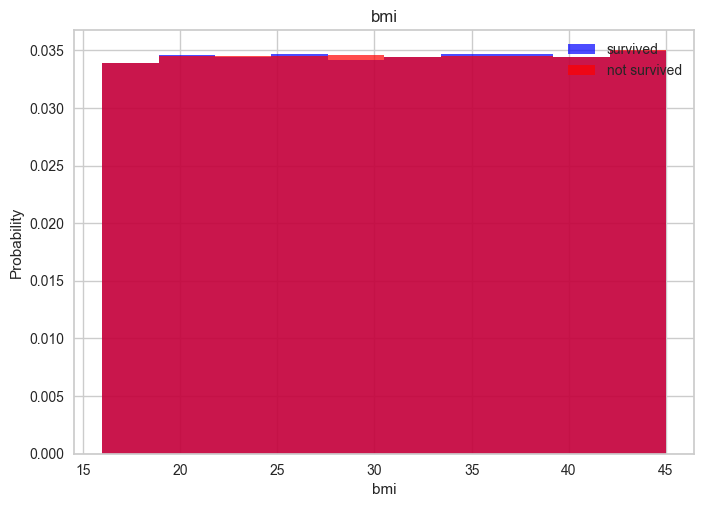

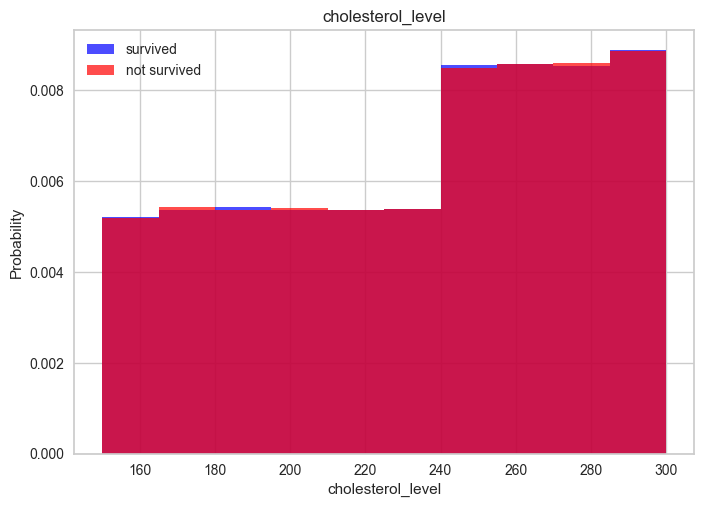

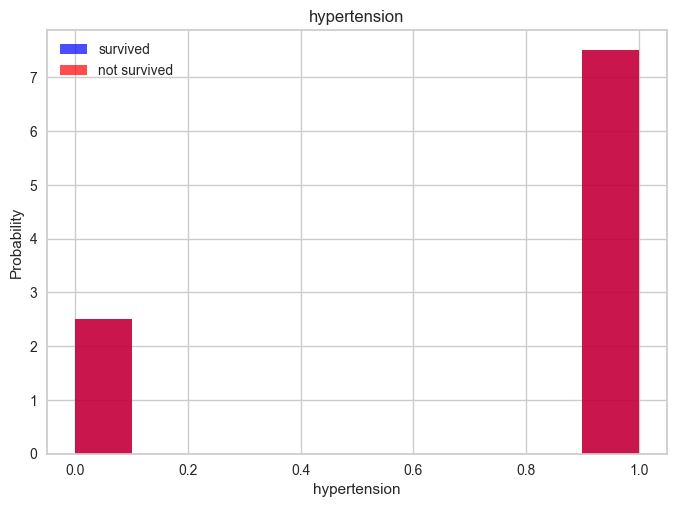

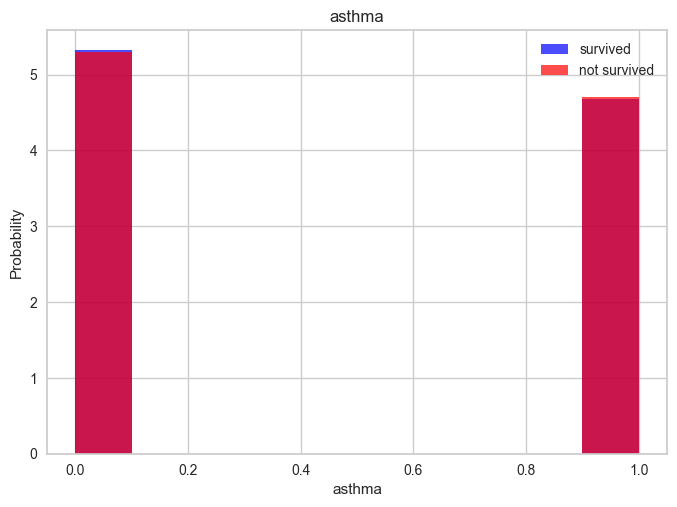

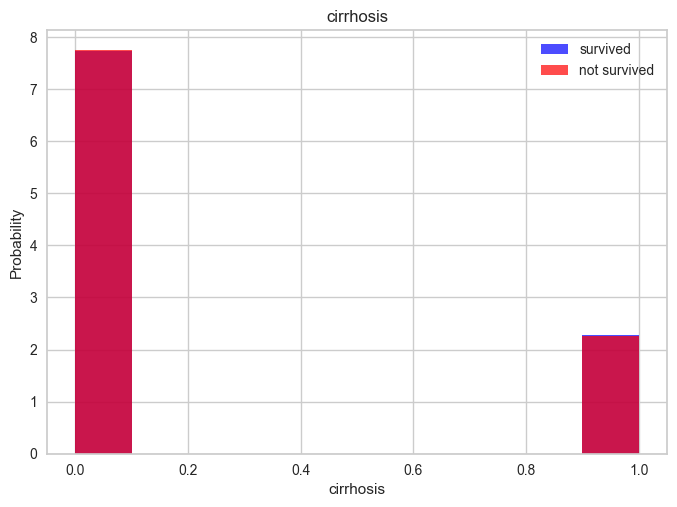

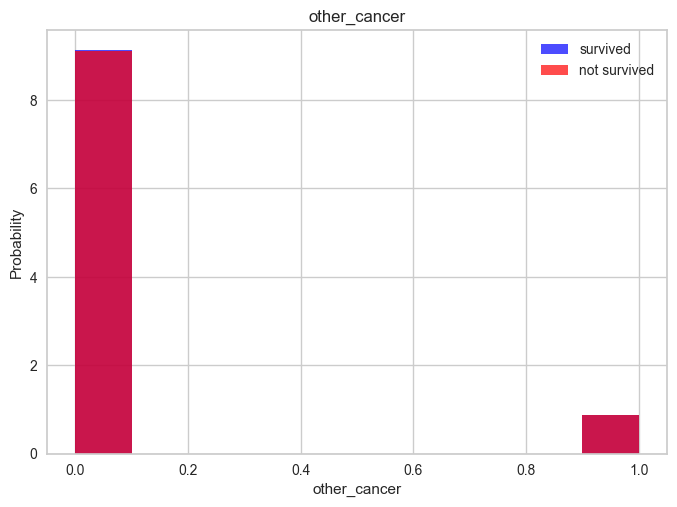

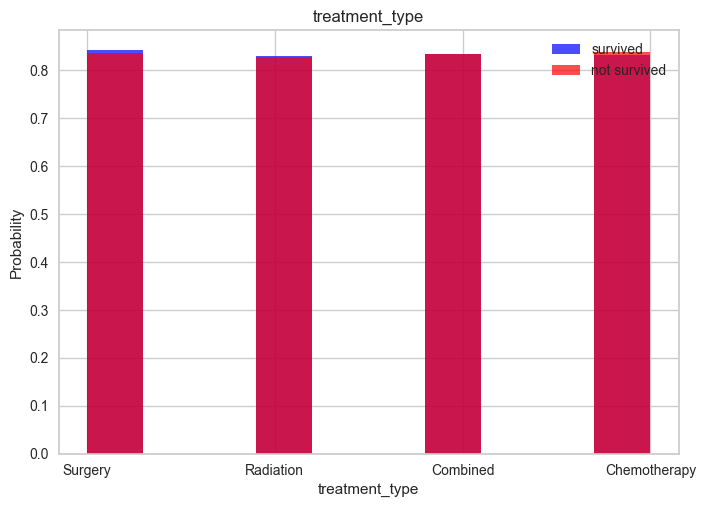

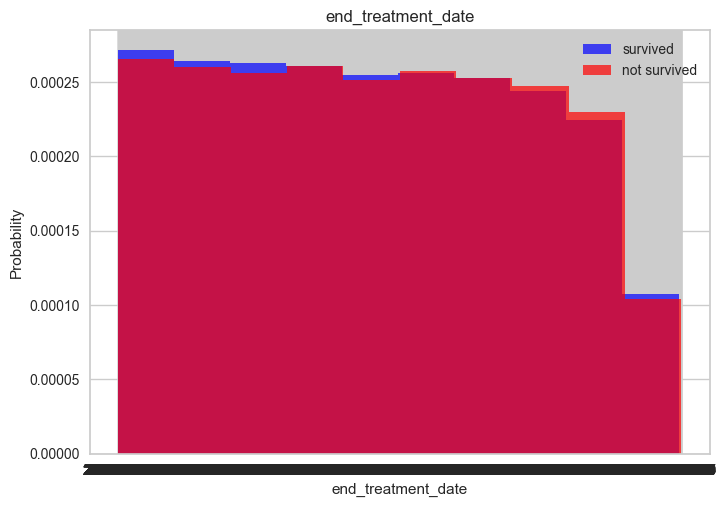

In [7]:
# Untuk Klasifikasi
for label in train_df.columns[:-1]:
  plt.hist(train_df[train_df["survived"]==1][label], color='blue', label='survived', alpha=0.7, density=True)
  plt.hist(train_df[train_df["survived"]==0][label], color='red', label='not survived', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

## **EDA For Insight Statistics Descriptiv**

### **Numeric**

In [8]:
train_df.describe()

,id,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,445000.500000,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229
std,256921.014127,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401
min,1.000000,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222500.750000,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,445000.500000,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,667500.250000,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,890000.000000,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


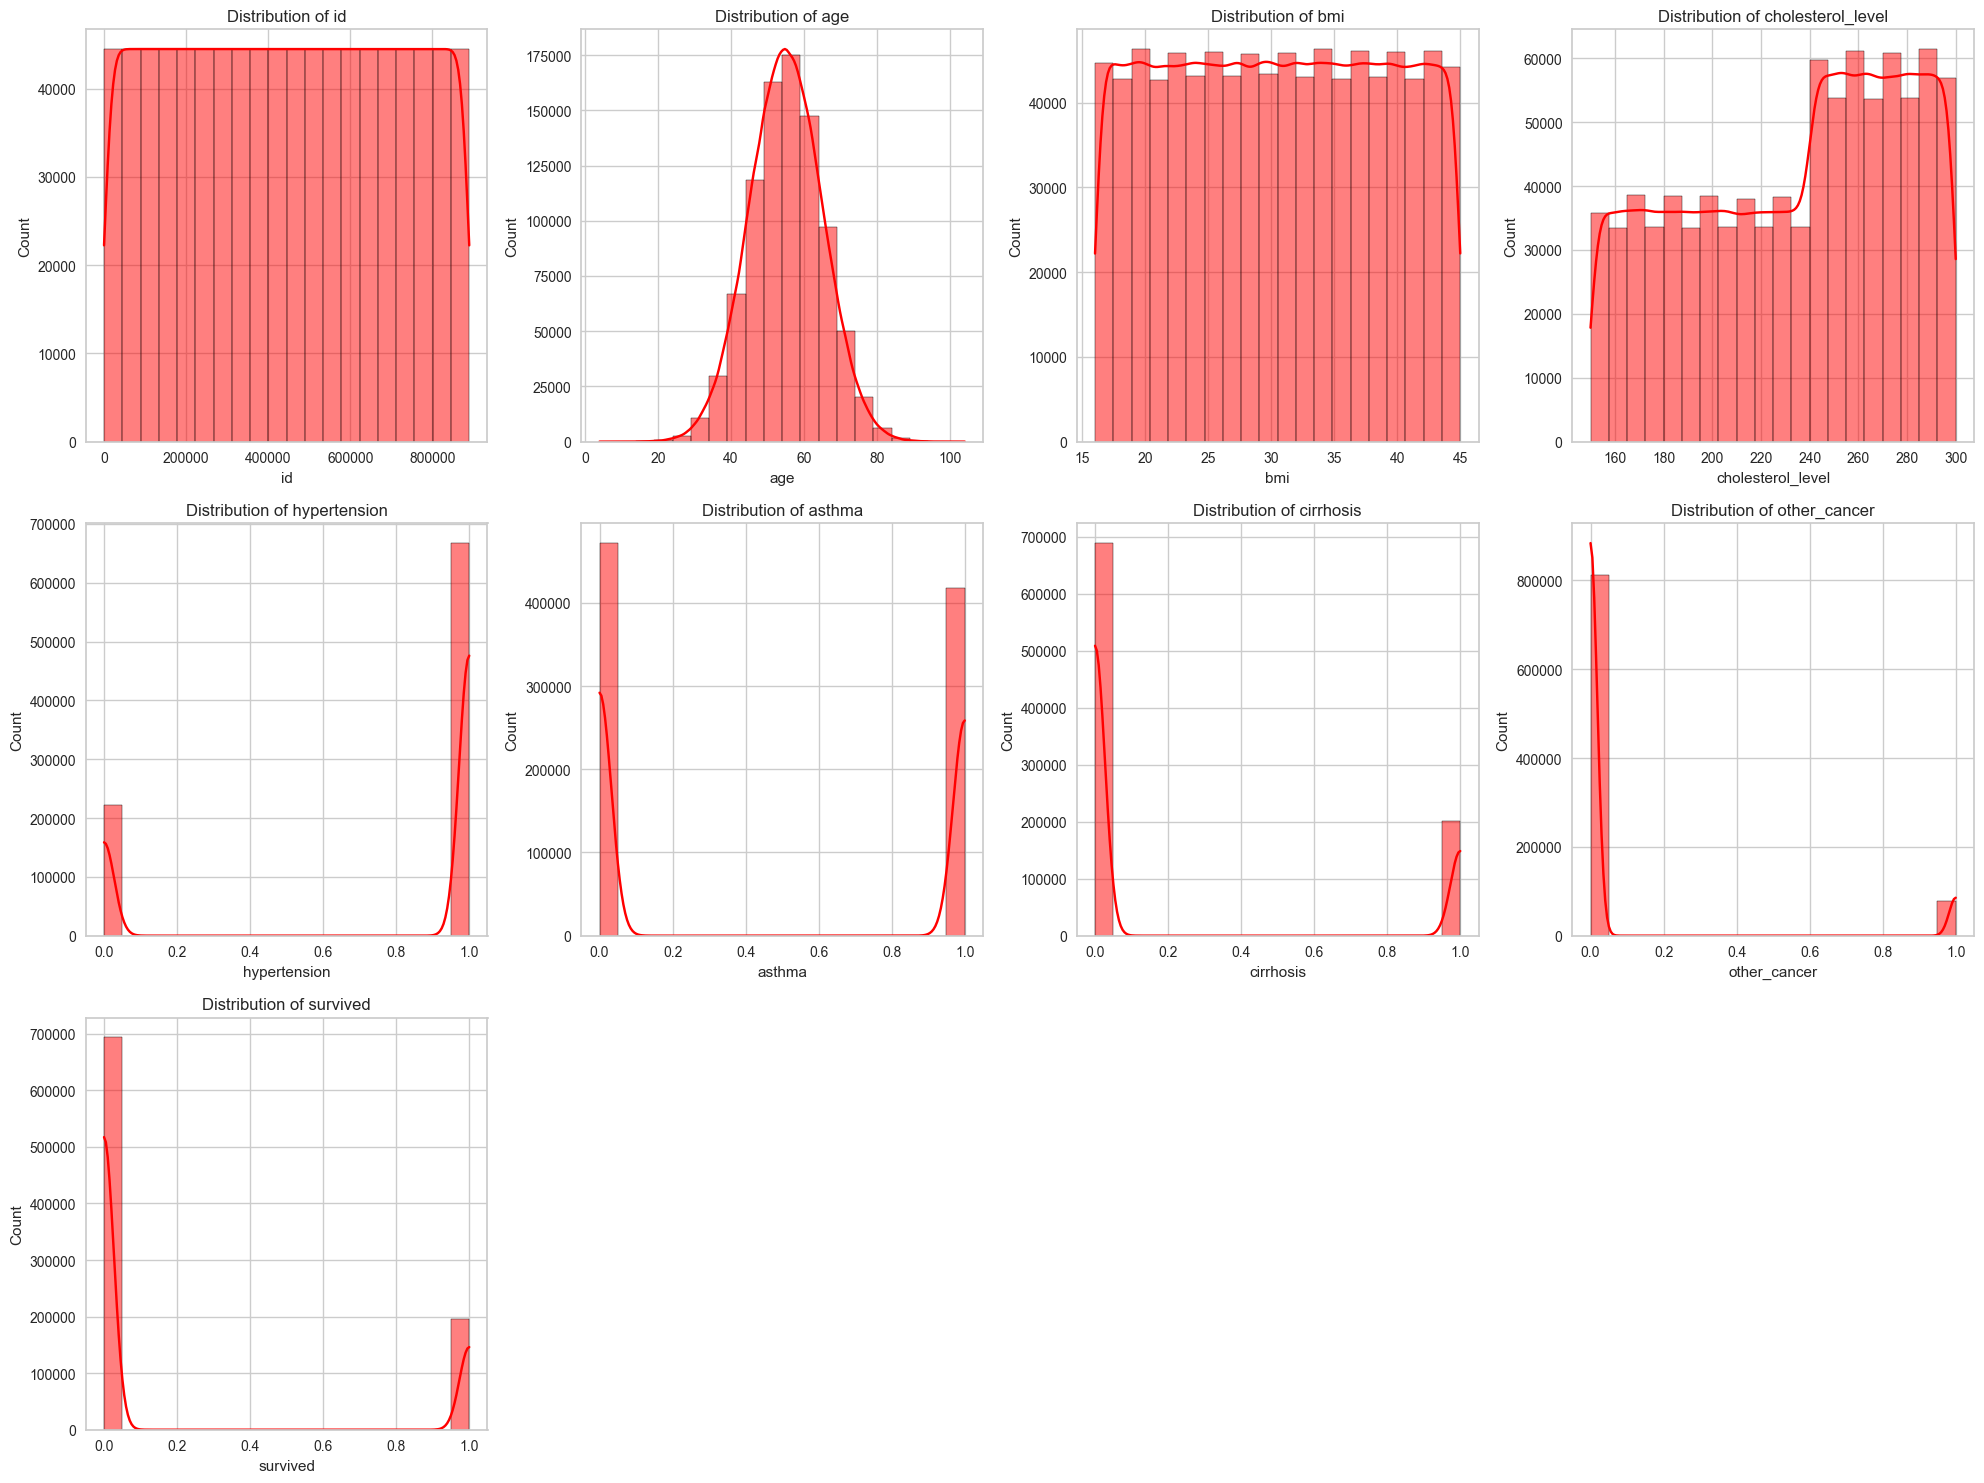

In [9]:
# EDA for Numeric Columns
size_num = len(num_col.columns)
rows = math.ceil(size_num / 4)
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, column in enumerate(num_col.columns):
    sns.histplot(train_df[column], bins=20, kde=True, color='red', ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **Categoric**

Plotting: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


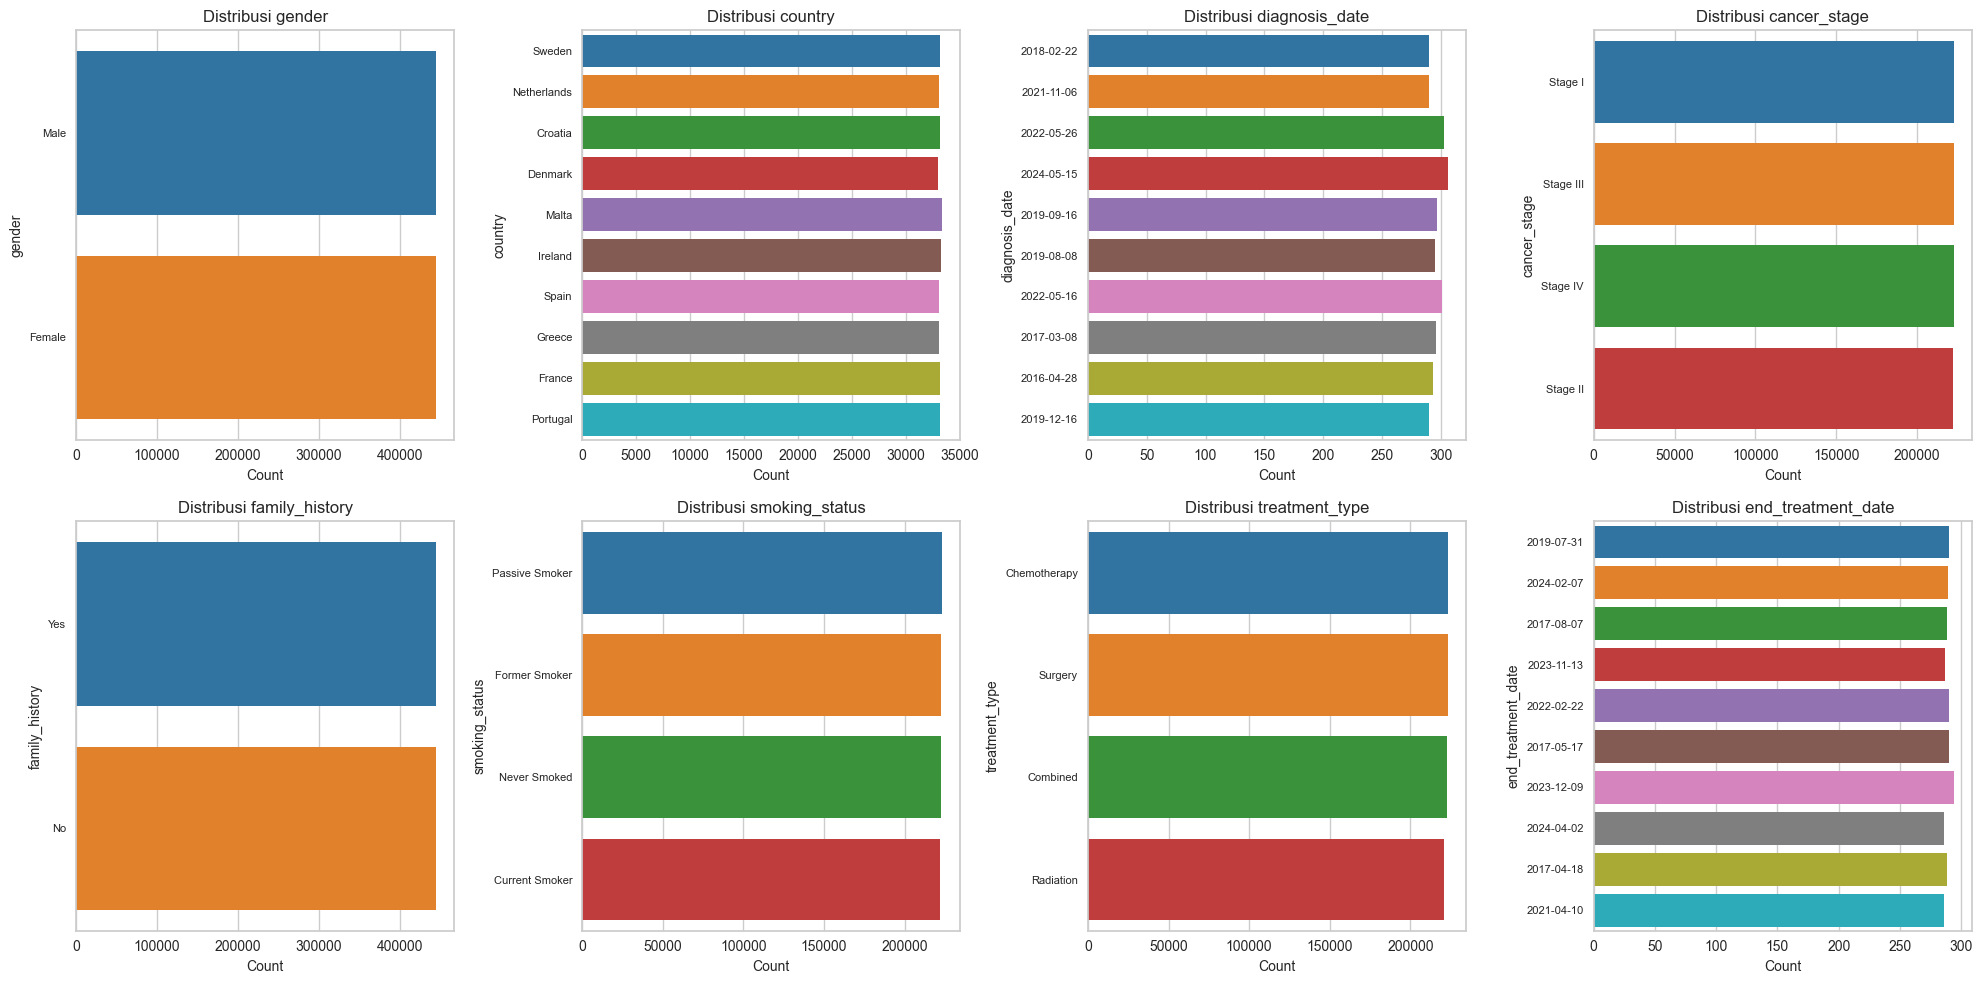

In [11]:
# EDA for Categoric Columns
size_cat = len(cat_col.columns)
rows = math.ceil(size_cat / 4)
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, column in tqdm(enumerate(cat_col.columns), total=size_cat, desc="Plotting"):
    top_categories = train_df[column].value_counts().nlargest(10).index
    filtered_df = train_df[train_df[column].isin(top_categories)]
    sns.countplot(y=filtered_df[column], hue=filtered_df[column], ax=axes[i], palette='tab10', legend=False)
    axes[i].set_title(f'Distribusi {column}', fontsize=12)
    axes[i].set_xlabel('Count', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)

    plt.setp(axes[i].get_yticklabels(), fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

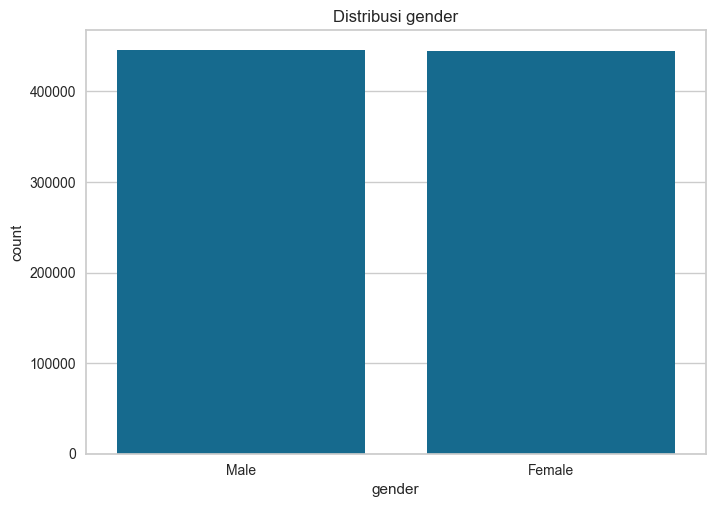

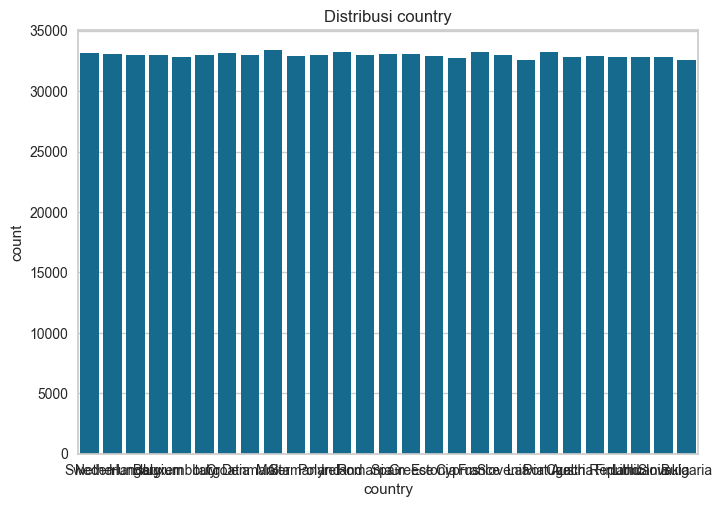

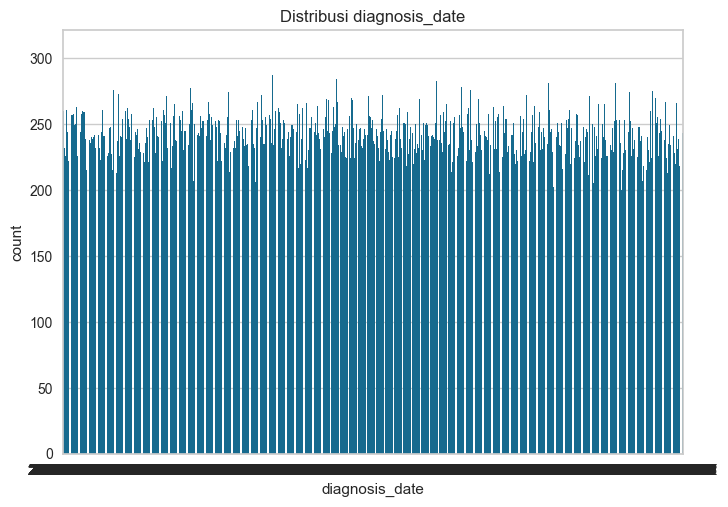

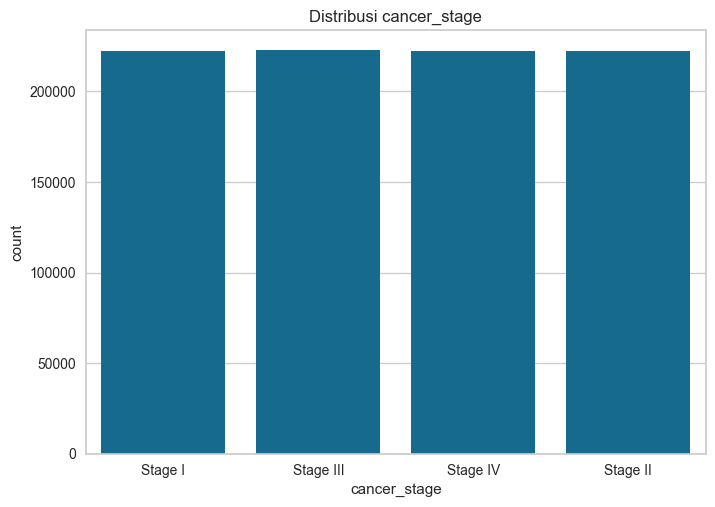

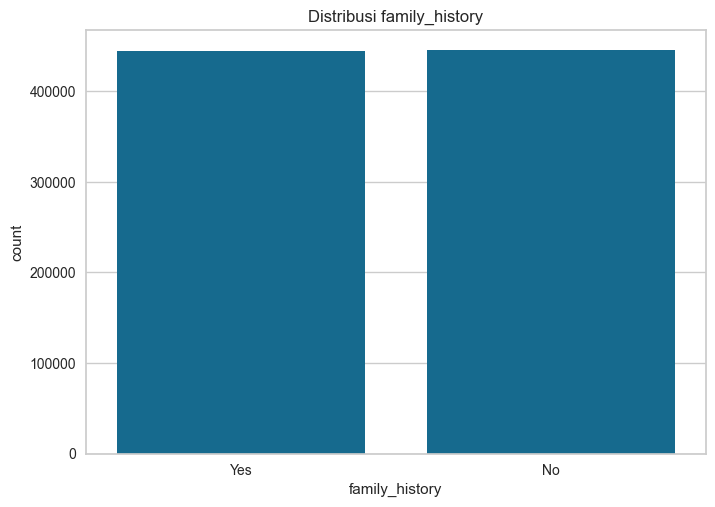

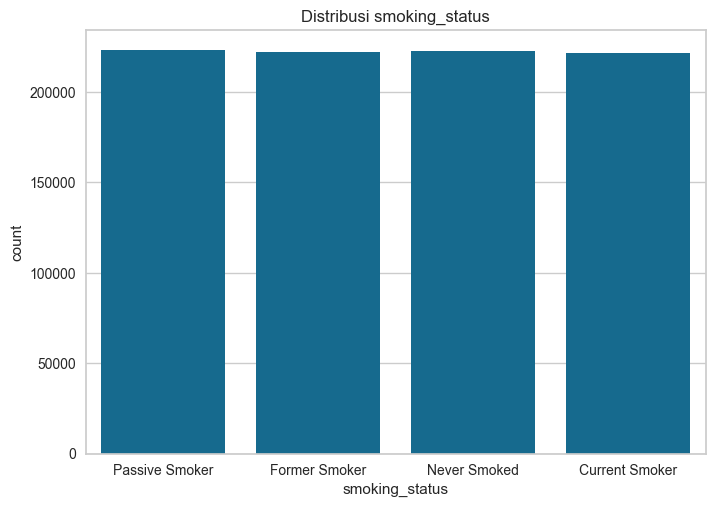

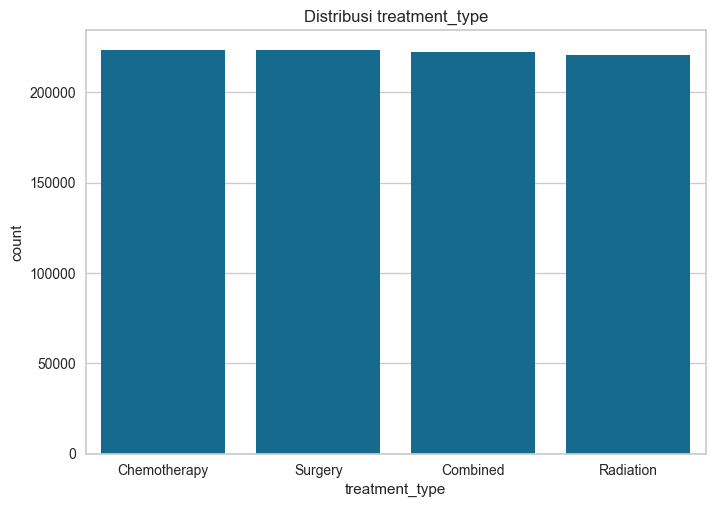

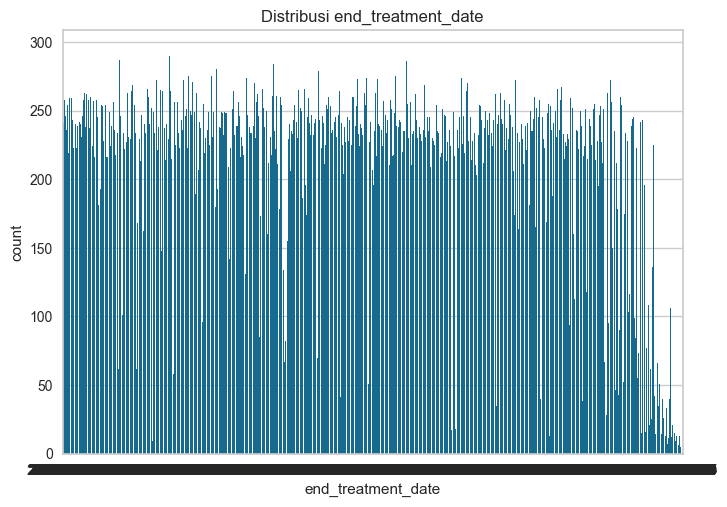

In [12]:
c_col = train_df.select_dtypes(include=object).columns

for col in c_col:
    sns.countplot(x=train_df[col])
    plt.title(f"Distribusi {col}")
    plt.show()

In [4]:
def hitung_proporsi_keseluruhan(v: pd.DataFrame, shape: int | float)  -> None:
    cat_col = list(v.select_dtypes(include=object).columns)
    cat_col.remove("diagnosis_date")
    cat_col.remove("end_treatment_date")
    for categoric in cat_col:
        print(f"Pada Kolom {categoric}")
        store_val_count = v[categoric].value_counts()
        dictionary_val_cnt = dict(store_val_count)
        convert_np_to_int = {k: float(v) for k, v in dictionary_val_cnt.items()}

        print(f"Total data ada {len(convert_np_to_int)}")
        for key, val in convert_np_to_int.items():
            print(f"Memiliki isi {key} memiliki total nilai sebanyak {val} dengan persentase {val/shape * 100:.2f}%")
        print("")

data_test = train_df.copy()

hitung_proporsi_keseluruhan(data_test, data_test.shape[0])    

Pada Kolom gender
Total data ada 2
Memiliki isi Male memiliki total nilai sebanyak 445134.0 dengan persentase 50.02%
Memiliki isi Female memiliki total nilai sebanyak 444866.0 dengan persentase 49.98%

Pada Kolom country
Total data ada 27
Memiliki isi Malta memiliki total nilai sebanyak 33367.0 dengan persentase 3.75%
Memiliki isi Ireland memiliki total nilai sebanyak 33243.0 dengan persentase 3.74%
Memiliki isi Portugal memiliki total nilai sebanyak 33208.0 dengan persentase 3.73%
Memiliki isi France memiliki total nilai sebanyak 33199.0 dengan persentase 3.73%
Memiliki isi Sweden memiliki total nilai sebanyak 33161.0 dengan persentase 3.73%
Memiliki isi Croatia memiliki total nilai sebanyak 33138.0 dengan persentase 3.72%
Memiliki isi Greece memiliki total nilai sebanyak 33052.0 dengan persentase 3.71%
Memiliki isi Spain memiliki total nilai sebanyak 33042.0 dengan persentase 3.71%
Memiliki isi Netherlands memiliki total nilai sebanyak 33040.0 dengan persentase 3.71%
Memiliki isi Den

In [5]:
def hitung_proporsi_keseluruhan(v: pd.DataFrame, shape: int | float, selamat: bool)  -> None:
    cat_col = list(v.select_dtypes(include=object).columns)
    cat_col.remove("diagnosis_date")
    cat_col.remove("end_treatment_date")
    for categoric in cat_col:
        print(f"Pada Kolom {categoric}")
        store_val_count = v[categoric].value_counts()
        dictionary_val_cnt = dict(store_val_count)
        convert_np_to_int = {k: float(v) for k, v in dictionary_val_cnt.items()}

        if selamat:
            print(f"Total data yang survived ada {len(convert_np_to_int)}")
            for key, val in convert_np_to_int.items():
                print(f"Memiliki isi {key} memiliki total nilai sebanyak {val} dengan persentase {val/shape * 100:.2f}%")
            print("")
        else:
            print(f"Total data yang not survived ada {len(convert_np_to_int)}")
            for key, val in convert_np_to_int.items():
                print(f"Memiliki isi {key} memiliki total nilai sebanyak {val} dengan persentase {val/shape * 100:.2f}%")
            print("")  

In [6]:
data_test = train_df.copy()
hitung_proporsi_keseluruhan(data_test[data_test['survived']==1], data_test.shape[0], selamat=True)  

Pada Kolom gender
Total data yang survived ada 2
Memiliki isi Male memiliki total nilai sebanyak 98172.0 dengan persentase 11.03%
Memiliki isi Female memiliki total nilai sebanyak 97832.0 dengan persentase 10.99%

Pada Kolom country
Total data yang survived ada 27
Memiliki isi Malta memiliki total nilai sebanyak 7426.0 dengan persentase 0.83%
Memiliki isi Portugal memiliki total nilai sebanyak 7372.0 dengan persentase 0.83%
Memiliki isi Netherlands memiliki total nilai sebanyak 7355.0 dengan persentase 0.83%
Memiliki isi Estonia memiliki total nilai sebanyak 7339.0 dengan persentase 0.82%
Memiliki isi Czech Republic memiliki total nilai sebanyak 7331.0 dengan persentase 0.82%
Memiliki isi Romania memiliki total nilai sebanyak 7318.0 dengan persentase 0.82%
Memiliki isi Spain memiliki total nilai sebanyak 7299.0 dengan persentase 0.82%
Memiliki isi Finland memiliki total nilai sebanyak 7296.0 dengan persentase 0.82%
Memiliki isi Croatia memiliki total nilai sebanyak 7287.0 dengan persen

In [7]:
data_test = train_df.copy()
hitung_proporsi_keseluruhan(data_test[data_test['survived']==0], data_test.shape[0], selamat=False)  

Pada Kolom gender
Total data yang not survived ada 2
Memiliki isi Female memiliki total nilai sebanyak 347034.0 dengan persentase 38.99%
Memiliki isi Male memiliki total nilai sebanyak 346962.0 dengan persentase 38.98%

Pada Kolom country
Total data yang not survived ada 27
Memiliki isi France memiliki total nilai sebanyak 26036.0 dengan persentase 2.93%
Memiliki isi Sweden memiliki total nilai sebanyak 25996.0 dengan persentase 2.92%
Memiliki isi Ireland memiliki total nilai sebanyak 25962.0 dengan persentase 2.92%
Memiliki isi Malta memiliki total nilai sebanyak 25941.0 dengan persentase 2.91%
Memiliki isi Croatia memiliki total nilai sebanyak 25851.0 dengan persentase 2.90%
Memiliki isi Portugal memiliki total nilai sebanyak 25836.0 dengan persentase 2.90%
Memiliki isi Italy memiliki total nilai sebanyak 25815.0 dengan persentase 2.90%
Memiliki isi Greece memiliki total nilai sebanyak 25797.0 dengan persentase 2.90%
Memiliki isi Denmark memiliki total nilai sebanyak 25778.0 dengan p

In [8]:
print(f"Data 0 : {693996/train_df.shape[0]*100} \nData 1 : {196004/train_df.shape[0]*100}")

Data 0 : 77.97707865168539 
Data 1 : 22.022921348314604


### **EDA For Target**

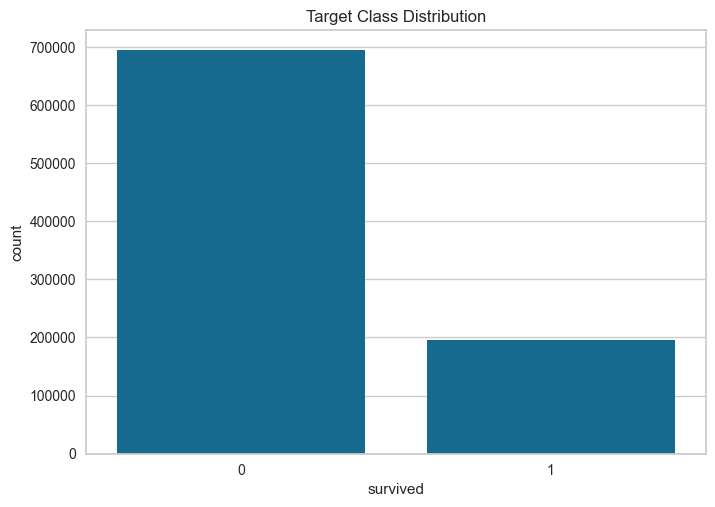

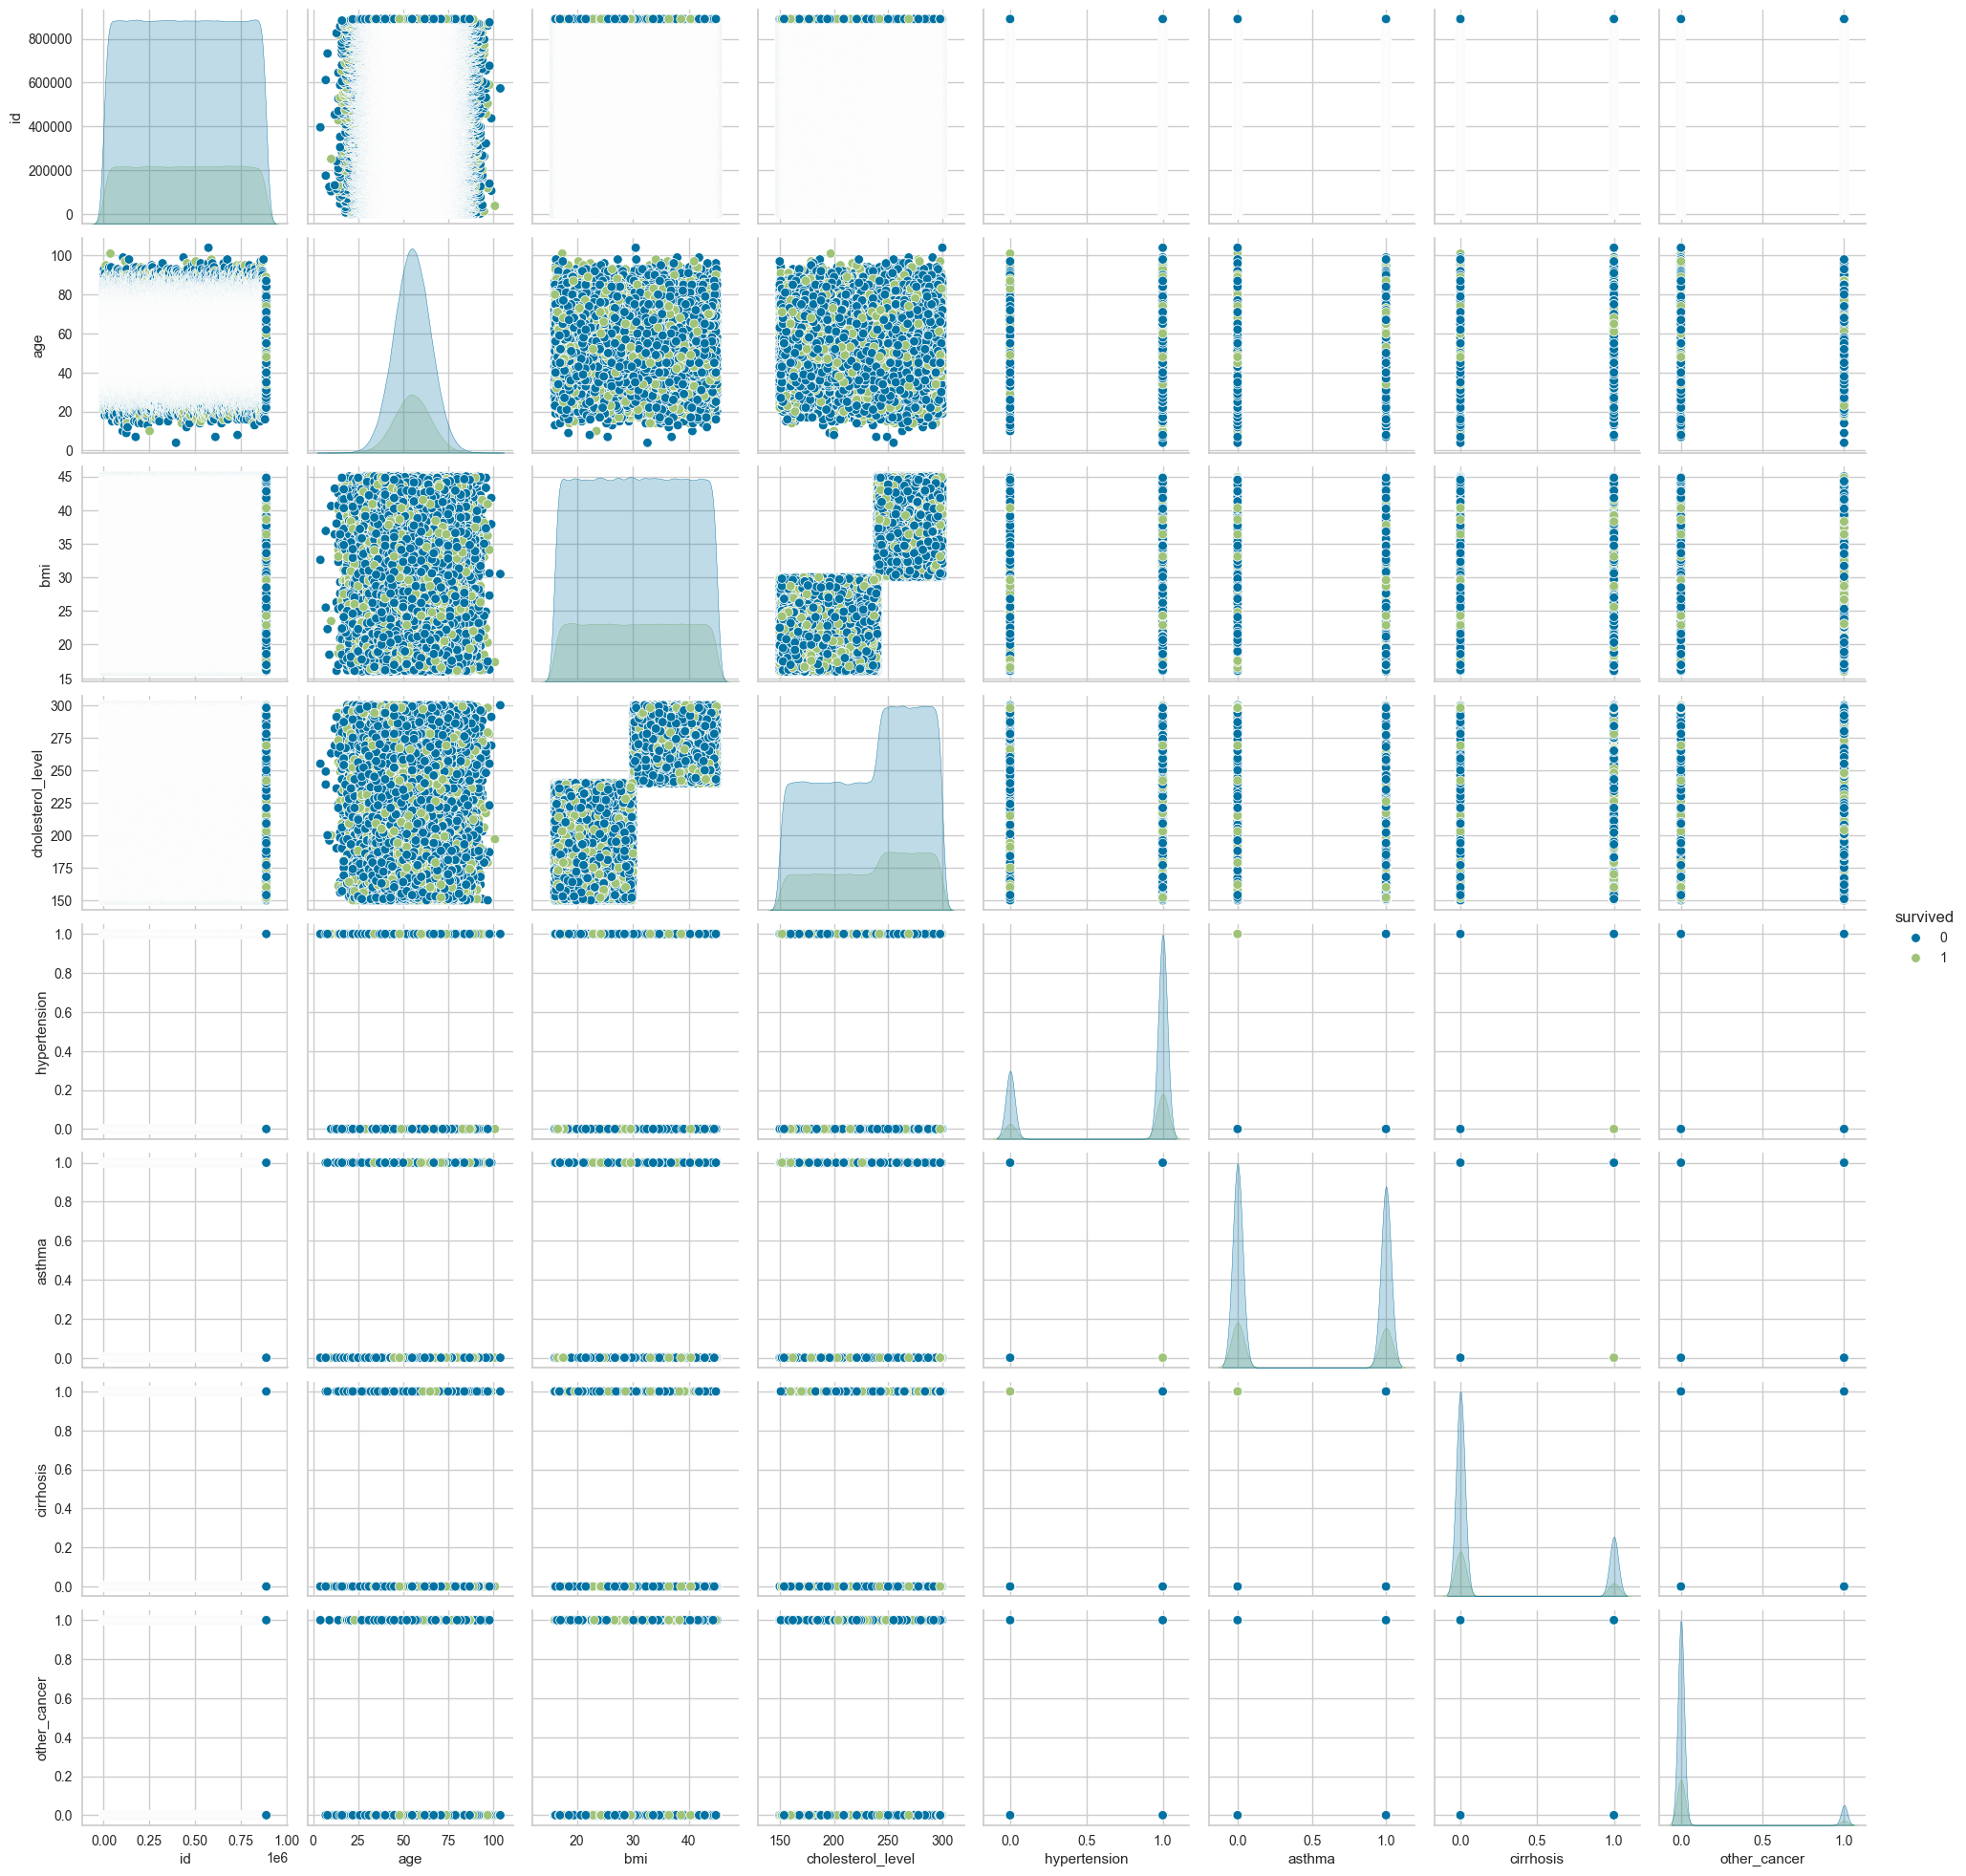

In [4]:
# Visualization Class Distribution
sns.countplot(x=train_df['survived'])
plt.title("Target Class Distribution")
plt.show()

# Visualization feature Distribution
sns.pairplot(train_df, hue='survived')
plt.show()

## **Check For Skew**

In [9]:
train_df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [12]:
def deteksi_skew(df: pd.DataFrame) -> None:
    numeric_cols = list(df.select_dtypes(include='number').columns)
    numeric_cols.remove('survived')
    numeric_cols.remove('id')

    hasil = []

    for kolom in numeric_cols:
        mean = df[kolom].mean()
        median = df[kolom].median()
        skew = df[kolom].skew()

        if mean > median:
            arah = "Skew Positif"
        elif mean < median:
            arah = "Skew Negatif"
        else:
            arah = "Simetris"

        hasil.append((kolom, round(mean, 2), round(median, 2), round(skew, 2), arah))
    hasil_df = pd.DataFrame(hasil, columns=['Kolom', 'Mean', 'Median', 'Skew', 'Arah Skew'])
    return hasil_df

In [13]:
hasil_skew = deteksi_skew(train_df)
hasil_skew

,Kolom,Mean,Median,Skew,Arah Skew
0,age,55.01,55.0,-0.00,Skew Positif
1,bmi,30.49,30.5,-0.00,Skew Negatif
2,cholesterol_level,233.63,242.0,-0.30,Skew Negatif
3,hypertension,0.75,1.0,-1.15,Skew Negatif
4,asthma,0.47,0.0,0.12,Skew Positif
5,cirrhosis,0.23,0.0,1.31,Skew Positif
6,other_cancer,0.09,0.0,2.91,Skew Positif


In [14]:
train_df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [16]:
def deteksi_outlier(train_df):
    numeric_cols = train_df.select_dtypes(include='number').columns
    hasil = []

    for kolom in numeric_cols:
        Q1 = train_df[kolom].quantile(0.25)
        Q3 = train_df[kolom].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        low_out = train_df[kolom] < lower_bound
        high_out = train_df[kolom] > upper_bound

        keterangan = []
        if low_out.any():
            keterangan.append("Ditemukan low outlier")
        else:
            keterangan.append("Tidak ada low outlier")

        if high_out.any():
            keterangan.append("Ditemukan high outlier")
        else:
            keterangan.append("Tidak ada high outlier")

        hasil.append((kolom, ' & '.join(keterangan)))

    return pd.DataFrame(hasil, columns=['Kolom', 'Status Outlier'])


In [17]:
num_col_out = deteksi_outlier(train_df=train_df)
num_col_out

,Kolom,Status Outlier
0,id,Tidak ada low outlier & Tidak ada high outlier
1,age,Ditemukan low outlier & Ditemukan high outlier
2,bmi,Tidak ada low outlier & Tidak ada high outlier
3,cholesterol_level,Tidak ada low outlier & Tidak ada high outlier
4,hypertension,Ditemukan low outlier & Tidak ada high outlier
5,asthma,Tidak ada low outlier & Tidak ada high outlier
6,cirrhosis,Tidak ada low outlier & Ditemukan high outlier
7,other_cancer,Tidak ada low outlier & Ditemukan high outlier
8,survived,Tidak ada low outlier & Ditemukan high outlier


In [18]:
train_df.select_dtypes(include=object)

,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,treatment_type,end_treatment_date
0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,Chemotherapy,2017-09-10
1,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,Surgery,2024-06-17
2,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,Combined,2024-04-09
3,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,Chemotherapy,2017-04-23
4,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,Combined,2025-01-08
...,...,...,...,...,...,...,...,...
889995,Male,Malta,2022-07-01,Stage IV,No,Passive Smoker,Radiation,2023-02-23
889996,Female,Cyprus,2015-09-27,Stage II,Yes,Former Smoker,Surgery,2017-06-19
889997,Female,Estonia,2016-03-27,Stage III,Yes,Never Smoked,Combined,2017-01-23
889998,Female,Slovakia,2015-12-22,Stage IV,Yes,Former Smoker,Chemotherapy,2017-12-12


In [20]:
train_df['country'].unique()

array(['Sweden', 'Netherlands', 'Hungary', 'Belgium', 'Luxembourg',
       'Italy', 'Croatia', 'Denmark', 'Malta', 'Germany', 'Poland',
       'Ireland', 'Romania', 'Spain', 'Greece', 'Estonia', 'Cyprus',
       'France', 'Slovenia', 'Latvia', 'Portugal', 'Austria',
       'Czech Republic', 'Finland', 'Lithuania', 'Slovakia', 'Bulgaria'],
      dtype=object)

In [21]:
train_df

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889995,889996,40.0,Male,Malta,2022-07-01,Stage IV,No,Passive Smoker,44.8,243,1,1,1,0,Radiation,2023-02-23,0
889996,889997,62.0,Female,Cyprus,2015-09-27,Stage II,Yes,Former Smoker,21.6,240,0,0,0,0,Surgery,2017-06-19,0
889997,889998,48.0,Female,Estonia,2016-03-27,Stage III,Yes,Never Smoked,38.6,242,1,0,0,0,Combined,2017-01-23,1
889998,889999,67.0,Female,Slovakia,2015-12-22,Stage IV,Yes,Former Smoker,18.6,194,1,1,0,0,Chemotherapy,2017-12-12,0


In [22]:
num_col = train_df.select_dtypes(include=np.number)

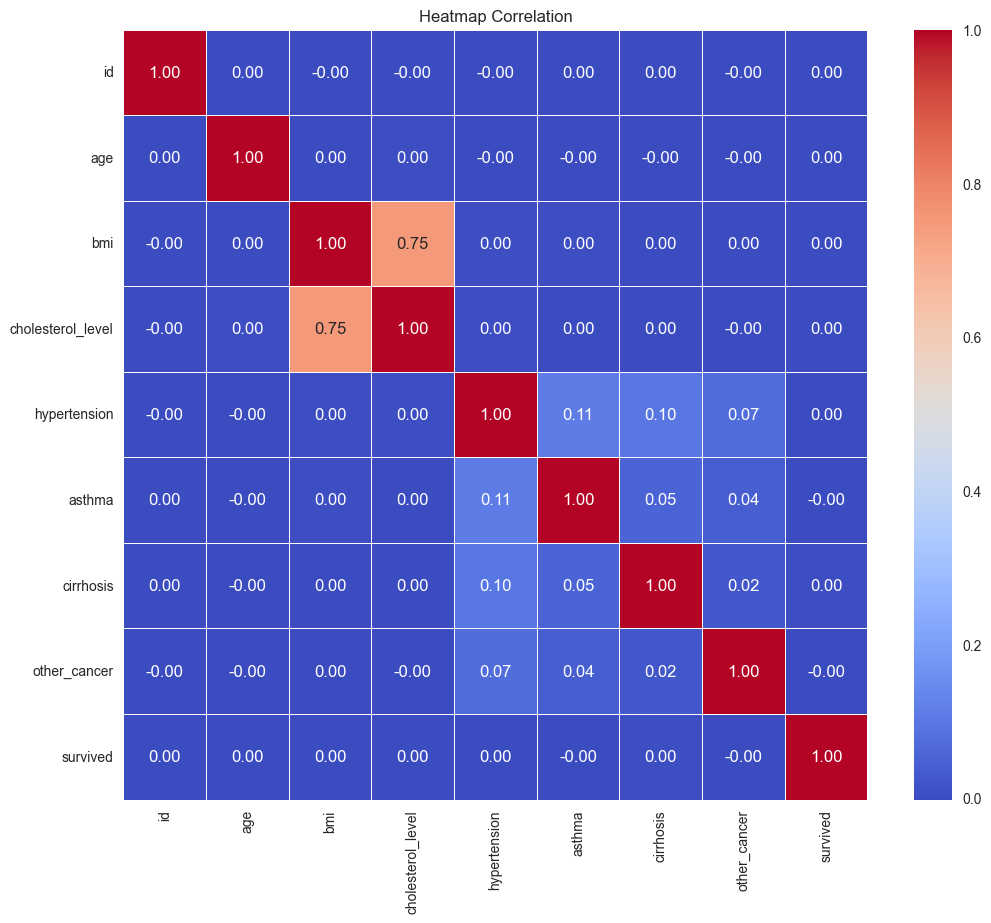

In [23]:
plt.figure(figsize=(12, 10))
correlation_matrix = num_col.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Correlation')
plt.show()

In [31]:
data_not_survived = train_df[train_df['survived']==0]
data_not_survived

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
5,6,50.0,Male,Italy,2023-01-02,Stage I,No,Never Smoked,37.6,274,1,0,0,0,Radiation,2024-12-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889994,889995,55.0,Male,Italy,2018-03-27,Stage III,Yes,Former Smoker,26.8,154,0,0,0,0,Radiation,2019-04-23,0
889995,889996,40.0,Male,Malta,2022-07-01,Stage IV,No,Passive Smoker,44.8,243,1,1,1,0,Radiation,2023-02-23,0
889996,889997,62.0,Female,Cyprus,2015-09-27,Stage II,Yes,Former Smoker,21.6,240,0,0,0,0,Surgery,2017-06-19,0
889998,889999,67.0,Female,Slovakia,2015-12-22,Stage IV,Yes,Former Smoker,18.6,194,1,1,0,0,Chemotherapy,2017-12-12,0


In [33]:
data_not_survived['smoking_status'].value_counts()

smoking_status
Passive Smoker    174067
Never Smoked      173543
Former Smoker     173381
Current Smoker    173005
Name: count, dtype: int64

In [34]:
train_df

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889995,889996,40.0,Male,Malta,2022-07-01,Stage IV,No,Passive Smoker,44.8,243,1,1,1,0,Radiation,2023-02-23,0
889996,889997,62.0,Female,Cyprus,2015-09-27,Stage II,Yes,Former Smoker,21.6,240,0,0,0,0,Surgery,2017-06-19,0
889997,889998,48.0,Female,Estonia,2016-03-27,Stage III,Yes,Never Smoked,38.6,242,1,0,0,0,Combined,2017-01-23,1
889998,889999,67.0,Female,Slovakia,2015-12-22,Stage IV,Yes,Former Smoker,18.6,194,1,1,0,0,Chemotherapy,2017-12-12,0


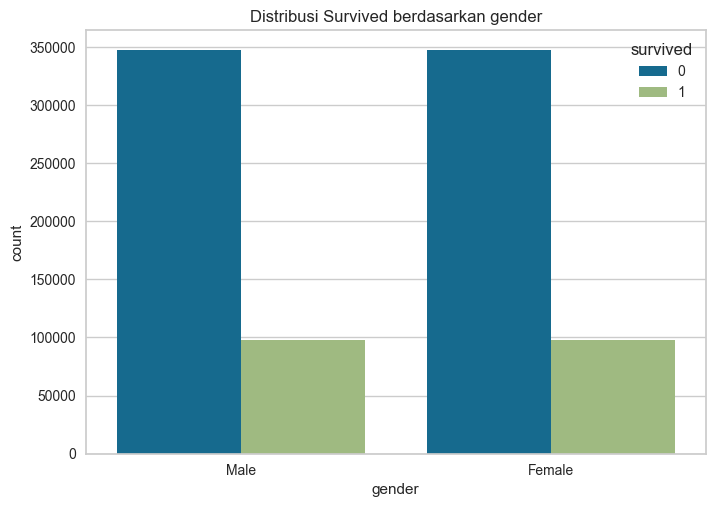

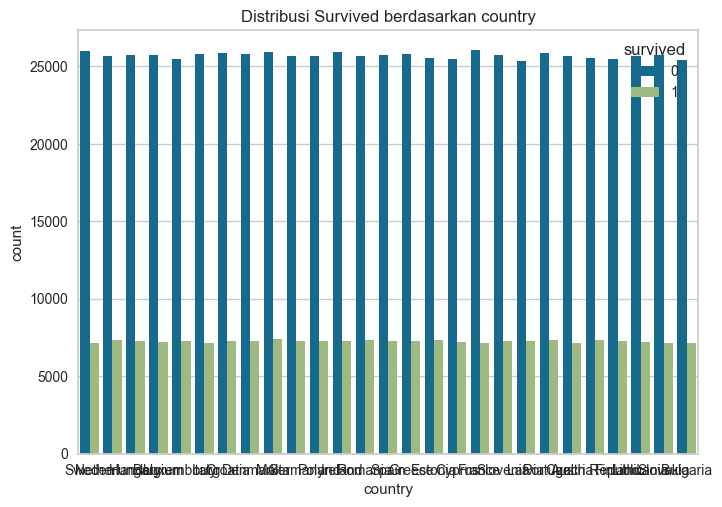

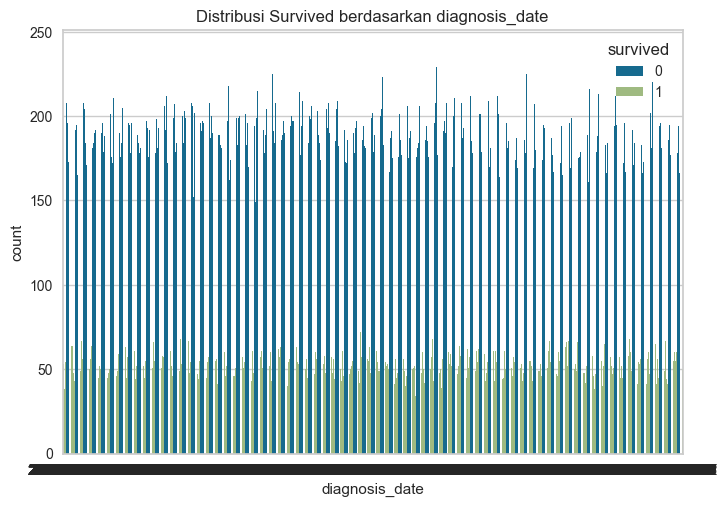

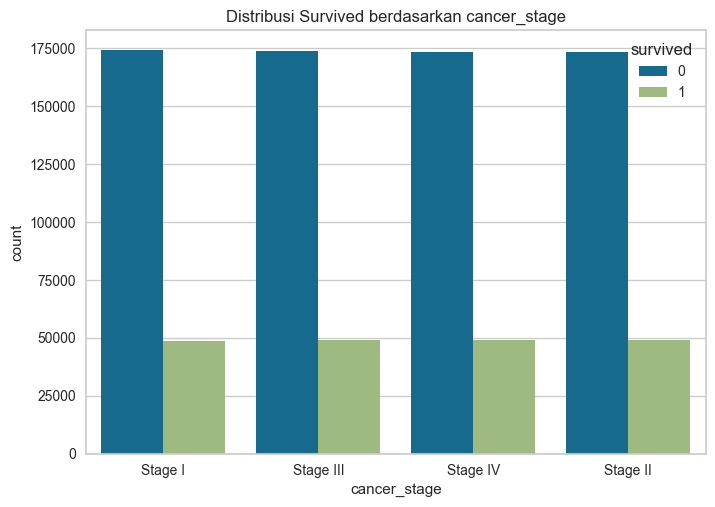

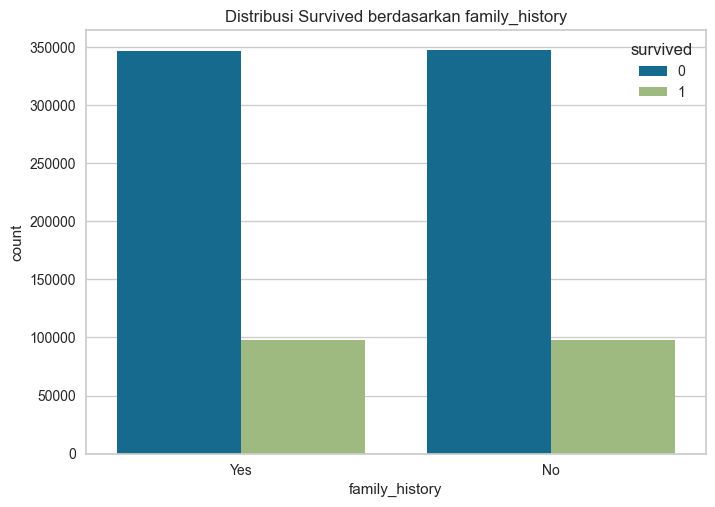

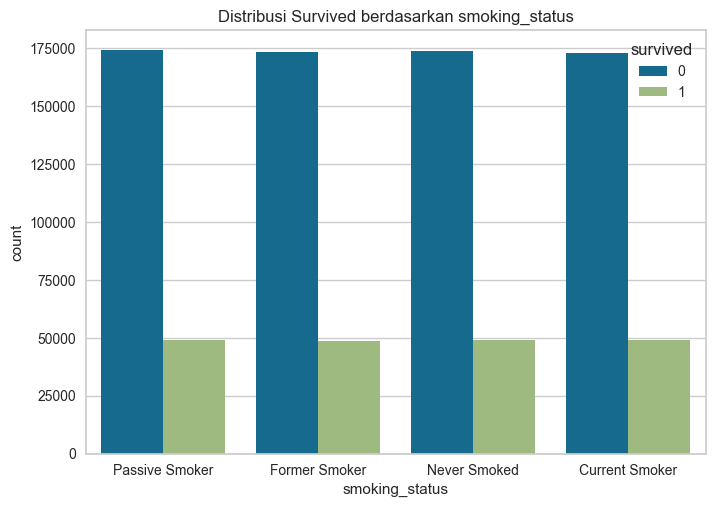

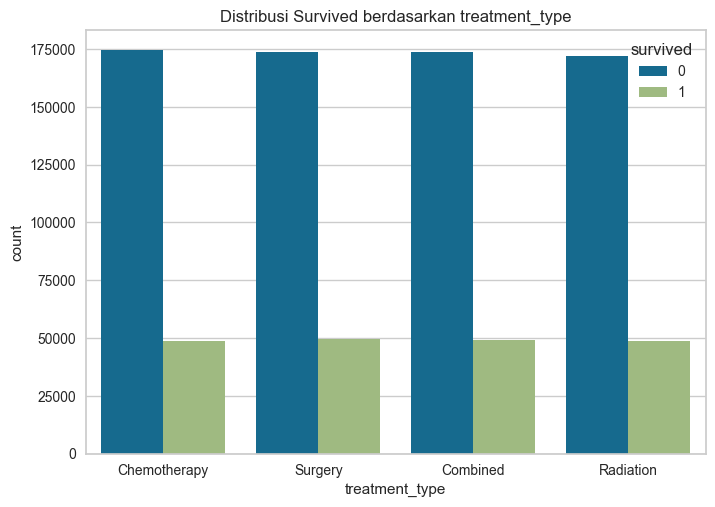

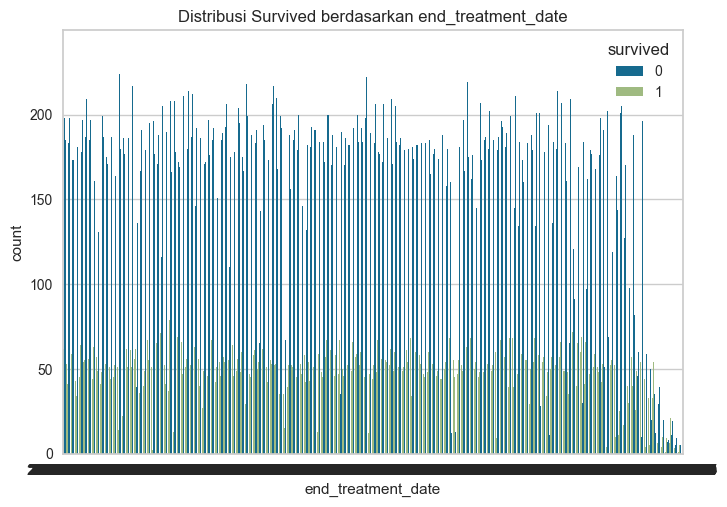

In [36]:
for i in train_df.select_dtypes(include=object).columns:
    sns.countplot(data=train_df, x=i, hue='survived')
    plt.title(f"Distribusi Survived berdasarkan {i}")
    plt.show()

In [38]:
saved = train_df[train_df['survived']==1]
saved['gender'].value_counts()

gender
Male      98172
Female    97832
Name: count, dtype: int64

In [39]:
print(f"Male : {98172/train_df.shape[0] * 100} \nFemale : {97832/train_df.shape[0] * 100}")

Male : 11.03056179775281 
Female : 10.992359550561797


# **Data Preparation**

In [40]:
train_df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


## **Dataset Splitting**

In [41]:
train_df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [42]:
train_df.drop(columns=['id','country', 'diagnosis_date', 'end_treatment_date'], inplace=True)

In [43]:
train_df.head(3)

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived
0,64.0,Male,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,0
1,50.0,Female,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,1
2,65.0,Female,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,0


In [44]:
df = train_df.copy()

In [49]:
Q1 = train_df['age'].quantile(0.25)
Q3 = train_df['age'].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (train_df['age'] < (Q1 - 1.5 * IQR)) | (train_df['age'] > (Q3 + 1.5 * IQR))
train_df = train_df[~outlier_mask]

In [50]:
X = train_df.drop(columns=['survived'], axis=1)
y = train_df['survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((708884, 12), (177221, 12), (708884,), (177221,))

# **Data Preparation**

In [51]:
X_train.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type
717046,51.0,Male,Stage II,No,Current Smoker,23.7,162,0,0,0,0,Combined
87002,71.0,Male,Stage I,Yes,Former Smoker,43.7,249,1,1,1,0,Radiation
660150,54.0,Female,Stage I,Yes,Never Smoked,24.2,160,1,1,1,0,Combined
505070,38.0,Male,Stage IV,Yes,Current Smoker,37.2,240,0,0,0,0,Combined
641535,60.0,Female,Stage I,No,Never Smoked,27.2,211,0,1,0,0,Radiation


In [52]:
cat_col = ['gender', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type']

In [55]:
# Label Encoder (For Huge Dataset)
encoder = LabelEncoder()

for column in cat_col:
    X_train[column] = encoder.fit_transform(X_train[column])
    X_val[column] = encoder.fit_transform(X_val[column])

### **Build new feature  (health score)**

In [56]:
X_train.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type
717046,51.0,1,1,0,0,23.7,162,0,0,0,0,1
87002,71.0,1,0,1,1,43.7,249,1,1,1,0,2
660150,54.0,0,0,1,2,24.2,160,1,1,1,0,1
505070,38.0,1,3,1,0,37.2,240,0,0,0,0,1
641535,60.0,0,0,0,2,27.2,211,0,1,0,0,2


In [59]:
scaler = StandardScaler()
pca = PCA(n_components=1)

feature_for_PCA_X_train = X_train[['bmi','cholesterol_level']]
X_train_scaled = scaler.fit_transform(feature_for_PCA_X_train)
X_train['health_score'] = pca.fit_transform(X_train_scaled)

feature_for_PCA_X_val = X_val[['bmi','cholesterol_level']]
X_val_scaled = scaler.transform(feature_for_PCA_X_val)
X_val['health_score'] = pca.transform(X_val_scaled)

In [62]:
X_train.drop(columns=['bmi', 'cholesterol_level'], inplace=True)
X_val.drop(columns=['bmi', 'cholesterol_level'], inplace=True)

In [63]:
#model_ada = AdaBoostClassifier()
#model_rf = RandomForestClassifier(random_state=42)
model_xgb = XGBClassifier(random_state=42)
#model_SVC = SVC(random_state=42)
#model_logreg = LogisticRegression(random_state=42)
#model_lgbm_clf = LGBMClassifier(
#    objective='binary',  # Ubah ke 'multiclass' jika masalahnya multi-kelas
#    boosting_type='gbdt',
#    num_leaves=41,
#    learning_rate=0.001,
#    colsample_bytree=1.0,
#    n_estimators=600
#)
#model_lgbm_clf = LGBMClassifier(
#    objective='binary',
#    boosting_type='gbdt',
#    num_leaves=41,
#    learning_rate=0.023,
#    colsample_bytree=1.0,
#    n_estimators=600,
#    metric='accuracy',
#    random_state=42
#)


In [64]:
#model_ada.fit(X_train, y_train)
#model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
#model_SVC.fit(X_train, y_train)
#model_logreg.fit(X_train, y_train)
#model_lgbm_clf.fit(
#    X_train, y_train,
#    eval_set=[(X_val, y_val)],
#    eval_metric="binary_logloss",
#    callbacks=[lightgbm.log_evaluation(30)]
#)
#model_lgbm_clf.fit(
#    X_train, y_train,
#    eval_set=[(X_val, y_val)],
#    eval_metric=['accuracy', 'logloss'],
#)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [72]:
# Score Training and Test model ada
#print(" Adaboost ".center(90, "="))
#print(f"Score Training adaaboost            : {model_ada.score(X_train, y_train)}")
#print(f"Score Testing adaaboost             : {model_ada.score(X_val, y_val)}")
#print("\n")

# Score Training and Test model XGB
#print(" XGB ".center(90, "="))
print("XGB Score : ")
print(f"Score Training XGB                  : {model_xgb.score(X_train, y_train)}")
print(f"Score Testing XGB                   : {model_xgb.score(X_val, y_val)}")
print("\n")

# Score Training and Test model LGBM Classification
#print(" LGBM Classification ".center(90, "="))
#print(f"Score Training LGBM Classification  : {model_lgbm_clf.score(X_train, y_train)}")
#print(f"Score Testing LGBM Classification   : {model_lgbm_clf.score(X_val, y_val)}")
#print("\n")

## Score Training and Test model Logistic Regression
#print(" Logistic Regression ".center(90, "="))
#print(f"Score Training Logistic Regression  : {model_logreg.score(X_train, y_train)}")
#print(f"Score Testing Logistic Regression   : {model_logreg.score(X_val, y_val)}")

XGB Score : 
Score Training XGB                  : 0.7799865704402977
Score Testing XGB                   : 0.779727007521682




Adaboost Evaluation : 
Classification Report Adaboost Model :
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000



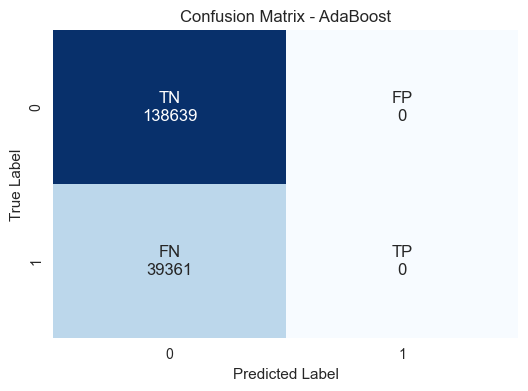

Adaboost Evaluation Score :
Precision (macro): 0.3894
Recall (macro): 0.5000
F1-Score (macro): 0.4378
ROC-AUC Score: 0.4992
PR-AUC Score: 0.2209
Matthews Correlation Coefficient (MCC): 0.0000
Cohen’s Kappa Score: 0.0000
Balanced Accuracy: 0.5000


In [24]:
print("Adaboost Evaluation : ")
y_val_pred_ada = model_ada.predict(X_val)
y_val_pred_proba_ada = model_ada.predict_proba(X_val)[:, 1]
roc_auc_ada = roc_auc_score(y_val, y_val_pred_proba_ada)
pr_auc_ada = average_precision_score(y_val, y_val_pred_proba_ada)
mcc_ada = matthews_corrcoef(y_val, y_val_pred_ada)
kappa_ada = cohen_kappa_score(y_val, y_val_pred_ada)
balanced_acc_ada = balanced_accuracy_score(y_val, y_val_pred_ada)

report_model_ada = classification_report(y_val, y_val_pred_ada, zero_division=0)
print("Classification Report Adaboost Model :")
print(report_model_ada)

# Confusion Matrix Adaboost Model
cm_model_ada = confusion_matrix(y_val, y_val_pred_ada)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_ada[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_ada, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

print("Adaboost Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_ada, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_ada, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_ada, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_ada:.4f}")
print(f"PR-AUC Score: {pr_auc_ada:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_ada:.4f}")
print(f"Cohen’s Kappa Score: {kappa_ada:.4f}")
print(f"Balanced Accuracy: {balanced_acc_ada:.4f}")

XGB Evaluation : 
Classification Report XGB Model :
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138196
           1       0.20      0.00      0.00     39025

    accuracy                           0.78    177221
   macro avg       0.49      0.50      0.44    177221
weighted avg       0.65      0.78      0.68    177221



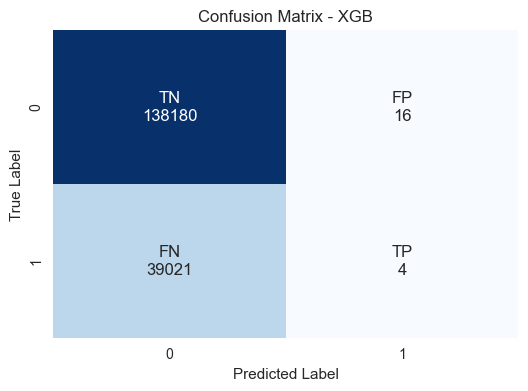

XGB Evaluation Score :
Precision (macro): 0.4899
Recall (macro): 0.5000
F1-Score (macro): 0.4382
ROC-AUC Score: 0.5010
PR-AUC Score: 0.2208
Matthews Correlation Coefficient (MCC): -0.0005
Cohen’s Kappa Score: -0.0000
Balanced Accuracy: 0.5000


In [66]:
print("XGB Evaluation : ")
y_val_pred_xgb = model_xgb.predict(X_val)
y_val_pred_proba_xgb = model_xgb.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)
pr_auc_xgb = average_precision_score(y_val, y_val_pred_proba_xgb)
mcc_xgb = matthews_corrcoef(y_val, y_val_pred_xgb)
kappa_xgb = cohen_kappa_score(y_val, y_val_pred_xgb)
balanced_acc_xgb = balanced_accuracy_score(y_val, y_val_pred_xgb)
report_model_xgb = classification_report(y_val, y_val_pred_xgb)
print("Classification Report XGB Model :")
print(report_model_xgb)

# Confusion Matrix XGB Model
cm_model_xgb = confusion_matrix(y_val, y_val_pred_xgb)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_xgb[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_xgb, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGB')
plt.show()

print("XGB Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"PR-AUC Score: {pr_auc_xgb:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_xgb:.4f}")
print(f"Cohen’s Kappa Score: {kappa_xgb:.4f}")
print(f"Balanced Accuracy: {balanced_acc_xgb:.4f}")

Logistic Regression Evaluation : 
Classification Report Logistic Regression Model :
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000



c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

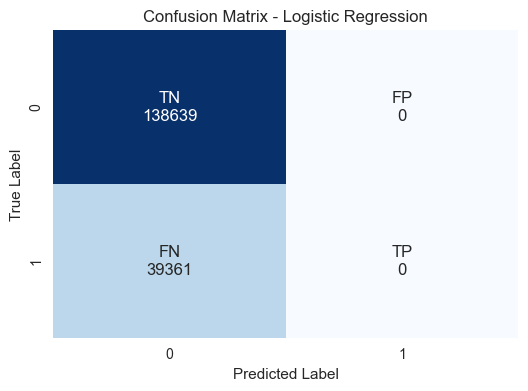

Logistic Regression Evaluation Score :
Precision (macro): 0.3894
Recall (macro): 0.5000
F1-Score (macro): 0.4378
ROC-AUC Score: 0.5019
PR-AUC Score: 0.2215
Matthews Correlation Coefficient (MCC): 0.0000
Cohen’s Kappa Score: 0.0000
Balanced Accuracy: 0.5000


In [26]:
print("Logistic Regression Evaluation : ")
y_val_pred_logreg = model_logreg.predict(X_val)
y_val_pred_proba_logreg = model_logreg.predict_proba(X_val)[:, 1]
roc_auc_logreg = roc_auc_score(y_val, y_val_pred_proba_logreg)
pr_auc_logreg = average_precision_score(y_val, y_val_pred_proba_logreg)
mcc_logreg = matthews_corrcoef(y_val, y_val_pred_logreg)
kappa_logreg = cohen_kappa_score(y_val, y_val_pred_logreg)
balanced_acc_logreg = balanced_accuracy_score(y_val, y_val_pred_logreg)
report_model_logreg = classification_report(y_val, y_val_pred_logreg)
print("Classification Report Logistic Regression Model :")
print(report_model_logreg)

# Confusion Matrix Logistic Regression Model
cm_model_logreg = confusion_matrix(y_val, y_val_pred_logreg)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_logreg[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_logreg, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("Logistic Regression Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_logreg, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_logreg, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_logreg, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_logreg:.4f}")
print(f"PR-AUC Score: {pr_auc_logreg:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_logreg:.4f}")
print(f"Cohen’s Kappa Score: {kappa_logreg:.4f}")
print(f"Balanced Accuracy: {balanced_acc_logreg:.4f}")

LGBM Classification Evaluation : 
Classification Report LGBM Classification Model :
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000



c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

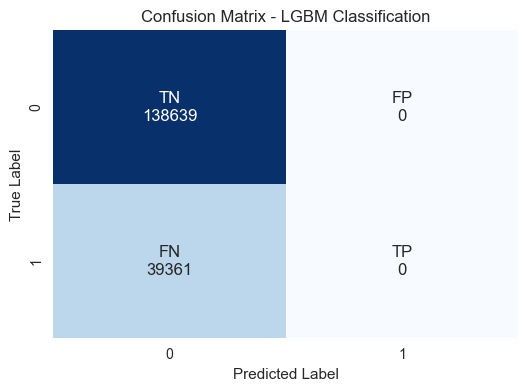

LGBM Classification Evaluation Score :
Precision (macro): 0.3894
Recall (macro): 0.5000
F1-Score (macro): 0.4378
ROC-AUC Score: 0.4988
PR-AUC Score: 0.2199
Matthews Correlation Coefficient (MCC): 0.0000
Cohen’s Kappa Score: 0.0000
Balanced Accuracy: 0.5000


In [27]:
print("LGBM Classification Evaluation : ")
y_val_pred_lgbm_clf = model_lgbm_clf.predict(X_val)
y_val_pred_proba_lgbm_clf = model_lgbm_clf.predict_proba(X_val)[:, 1]
roc_auc_lgbm_clf = roc_auc_score(y_val, y_val_pred_proba_lgbm_clf)
pr_auc_lgbm_clf = average_precision_score(y_val, y_val_pred_proba_lgbm_clf)
mcc_lgbm_clf = matthews_corrcoef(y_val, y_val_pred_lgbm_clf)
kappa_lgbm_clf = cohen_kappa_score(y_val, y_val_pred_lgbm_clf)
balanced_acc_lgbm_clf = balanced_accuracy_score(y_val, y_val_pred_lgbm_clf)
report_model_lgbm_clf = classification_report(y_val, y_val_pred_lgbm_clf)
print("Classification Report LGBM Classification Model :")
print(report_model_lgbm_clf)

# Confusion Matrix LGBM Classification Model
cm_model_lgbm_clf = confusion_matrix(y_val, y_val_pred_lgbm_clf)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_lgbm_clf[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_lgbm_clf, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LGBM Classification')
plt.show()

print("LGBM Classification Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_lgbm_clf, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_lgbm_clf, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_lgbm_clf, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_lgbm_clf:.4f}")
print(f"PR-AUC Score: {pr_auc_lgbm_clf:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_lgbm_clf:.4f}")
print(f"Cohen’s Kappa Score: {kappa_lgbm_clf:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lgbm_clf:.4f}")

# **Solve Imbalance Dataset**

In [73]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1105566, 11), (1105566,), (177221, 11), (177221,))

In [76]:
model_xgb_new = XGBClassifier()
model_xgb_new.fit(X_train, y_train)
print("XGB Score : ")
print(f"Score Training XGB                  : {model_xgb_new.score(X_train, y_train)}")
print(f"Score Testing XGB                   : {model_xgb_new.score(X_val, y_val)}")
print("\n")

XGB Score : 
Score Training XGB                  : 0.5775331368728778
Score Testing XGB                   : 0.538305279848325




XGB Evaluation : 
Classification Report XGB Model :
              precision    recall  f1-score   support

           0       0.78      0.57      0.66    138196
           1       0.22      0.43      0.29     39025

    accuracy                           0.54    177221
   macro avg       0.50      0.50      0.47    177221
weighted avg       0.66      0.54      0.58    177221



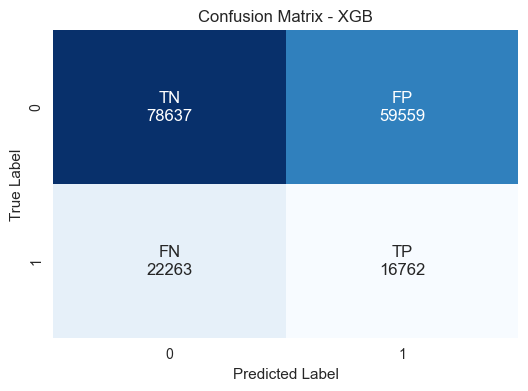

XGB Evaluation Score :
Precision (macro): 0.4995
Recall (macro): 0.4993
F1-Score (macro): 0.4742
ROC-AUC Score: 0.4996
PR-AUC Score: 0.2200
Matthews Correlation Coefficient (MCC): -0.0012
Cohen’s Kappa Score: -0.0011
Balanced Accuracy: 0.4993


In [77]:
print("XGB Evaluation : ")
y_val_pred_xgb = model_xgb_new.predict(X_val)
y_val_pred_proba_xgb = model_xgb_new.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_val_pred_proba_xgb)
pr_auc_xgb = average_precision_score(y_val, y_val_pred_proba_xgb)
mcc_xgb = matthews_corrcoef(y_val, y_val_pred_xgb)
kappa_xgb = cohen_kappa_score(y_val, y_val_pred_xgb)
balanced_acc_xgb = balanced_accuracy_score(y_val, y_val_pred_xgb)
report_model_xgb = classification_report(y_val, y_val_pred_xgb)
print("Classification Report XGB Model :")
print(report_model_xgb)

# Confusion Matrix XGB Model
cm_model_xgb = confusion_matrix(y_val, y_val_pred_xgb)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_xgb[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_xgb, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGB')
plt.show()

print("XGB Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"PR-AUC Score: {pr_auc_xgb:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_xgb:.4f}")
print(f"Cohen’s Kappa Score: {kappa_xgb:.4f}")
print(f"Balanced Accuracy: {balanced_acc_xgb:.4f}")

In [78]:
rsp_xgb = XGBClassifier()
rsp_param_xgb = {
    'max_depth': randint(1, 10),
    'learning_rate': loguniform(1e-2, 1e-1),
    'n_estimators': randint(100, 200),
    'subsample': uniform(0.3, 0.5),
    'gamma': randint(1, 10),
    'colsample_bytree': uniform(0.1, 0.9),
    'reg_alpha': loguniform(1e-3, 10),
    'reg_lambda': loguniform(1e-3, 10)
}

model_clf_xgb_rsp = RandomizedSearchCV(estimator=rsp_xgb, param_distributions=rsp_param_xgb, n_iter=70, cv=5, n_jobs=-1, verbose=1)
model_clf_xgb_rsp.fit(X_train, y_train)
print(f"Model best params : {model_clf_xgb_rsp.best_params_}")
print(f"Hasil train       : {model_clf_xgb_rsp.score(X_train, y_train)}")
print(f"Hasil test        : {model_clf_xgb_rsp.score(X_val, y_val)}")

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Model best params : {'colsample_bytree': np.float64(0.9443659303582669), 'gamma': 2, 'learning_rate': np.float64(0.09206743420969514), 'max_depth': 8, 'n_estimators': 144, 'reg_alpha': np.float64(0.01399806834606649), 'reg_lambda': np.float64(0.3450601718974981), 'subsample': np.float64(0.732905187492831)}
Hasil train       : 0.5856656228574323
Hasil test        : 0.5226468646492233


XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation : 
Classification Report LGBM Classification Model :
              precision    recall  f1-score   support

           0       0.78      0.54      0.64    138196
           1       0.22      0.46      0.30     39025

    accuracy                           0.52    177221
   macro avg       0.50      0.50      0.47    177221
weighted avg       0.66      0.52      0.56    177221



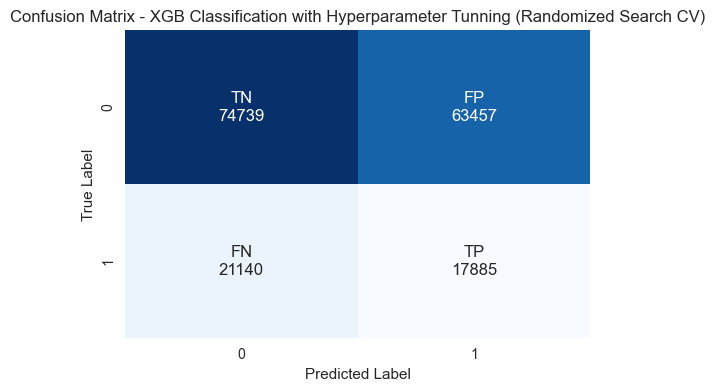

XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation Score :
Precision (macro): 0.4997
Recall (macro): 0.4996
F1-Score (macro): 0.4679
ROC-AUC Score: 0.5005
PR-AUC Score: 0.2204
Matthews Correlation Coefficient (MCC): -0.0007
Cohen’s Kappa Score: -0.0006
Balanced Accuracy: 0.4996


In [79]:
print("XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation : ")
best_model_xgb_rsp = model_clf_xgb_rsp.best_estimator_
y_val_pred_lgbm_clf_rsp = best_model_xgb_rsp.predict(X_val)
y_val_pred_proba_lgbm_clf_rsp = best_model_xgb_rsp.predict_proba(X_val)[:, 1]
roc_auc_lgbm_clf_rsp = roc_auc_score(y_val, y_val_pred_proba_lgbm_clf_rsp)
pr_auc_lgbm_clf_rsp = average_precision_score(y_val, y_val_pred_proba_lgbm_clf_rsp)
mcc_lgbm_clf_rsp = matthews_corrcoef(y_val, y_val_pred_lgbm_clf_rsp)
kappa_lgbm_clf_rsp = cohen_kappa_score(y_val, y_val_pred_lgbm_clf_rsp)
balanced_acc_lgbm_clf_rsp = balanced_accuracy_score(y_val, y_val_pred_lgbm_clf_rsp)
report_model_lgbm_clf_rsp = classification_report(y_val, y_val_pred_lgbm_clf_rsp)
print("Classification Report LGBM Classification Model :")
print(report_model_lgbm_clf_rsp)

# Confusion Matrix LGBM Classification Model
cm_model_lgbm_clf_rsp = confusion_matrix(y_val, y_val_pred_lgbm_clf_rsp)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_lgbm_clf_rsp[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_lgbm_clf_rsp, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGB Classification with Hyperparameter Tunning (Randomized Search CV)')
plt.show()

print("XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_lgbm_clf_rsp, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_lgbm_clf_rsp, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_lgbm_clf_rsp, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_lgbm_clf_rsp:.4f}")
print(f"PR-AUC Score: {pr_auc_lgbm_clf_rsp:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_lgbm_clf_rsp:.4f}")
print(f"Cohen’s Kappa Score: {kappa_lgbm_clf_rsp:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lgbm_clf_rsp:.4f}")

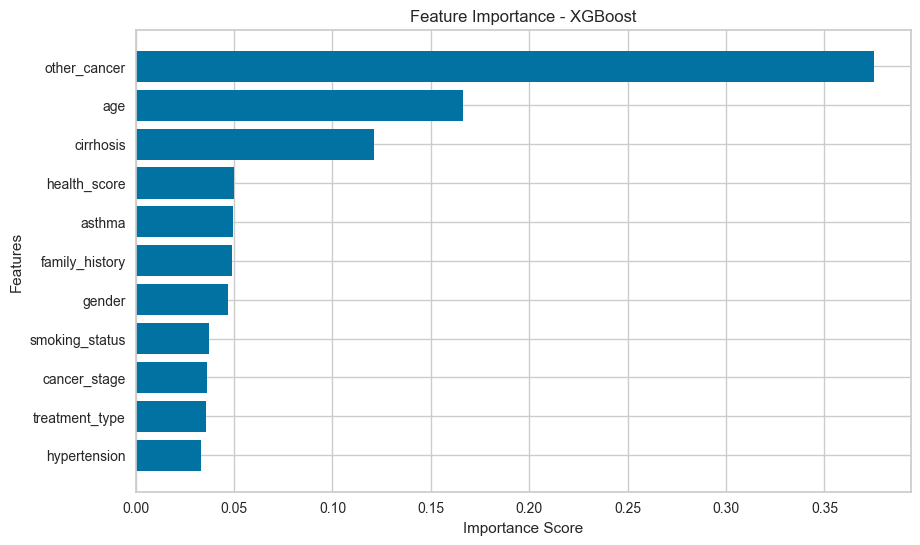

In [ ]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_clf_xgb_rsp.best_estimator_.feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

In [81]:
bsp_xgb = XGBClassifier()
bsp_param_xgb = {
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.01, 1, prior='log-uniform'),
    'n_estimators': Integer(100, 200),
    'subsample': Real(0.3, 0.8),
    'gamma': Integer(1, 10),
    'colsample_bytree': Real(0.1, 1),
    'reg_alpha': Real(0.001, 10, prior='log-uniform'),
    'reg_lambda': Real(0.001, 10, prior='log-uniform')
}

model_clf_xgb_bsp = BayesSearchCV(
    estimator=bsp_xgb,
    search_spaces=bsp_param_xgb,
    n_iter=70,
    cv=5,
    scoring='accuracy',  # atau 'r2', 'neg_mean_absolute_error' | Kalo klasifikasi ubah ke accuracy
    n_jobs=-1,
    verbose=1
)
model_clf_xgb_bsp.fit(X_train, y_train)
print(f"Model best params : {model_clf_xgb_bsp.best_params_}")
print(f"Hasil train       : {model_clf_xgb_bsp.score(X_train, y_train)}")
print(f"Hasil test        : {model_clf_xgb_bsp.score(X_val, y_val)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation : 
Classification Report LGBM Classification Model :
              precision    recall  f1-score   support

           0       0.78      0.62      0.69    138196
           1       0.22      0.38      0.28     39025

    accuracy                           0.57    177221
   macro avg       0.50      0.50      0.48    177221
weighted avg       0.66      0.57      0.60    177221



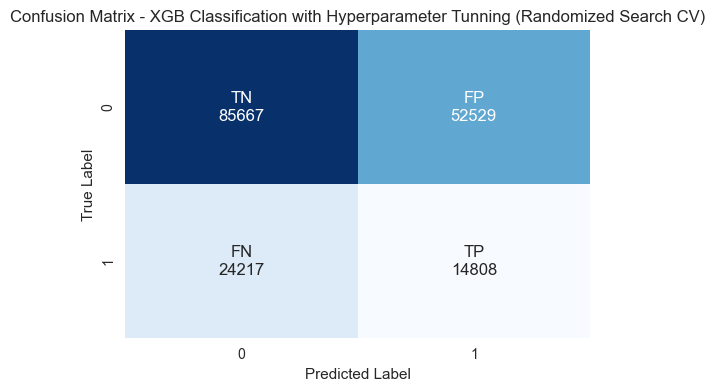

XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation Score :
Precision (macro): 0.4998
Recall (macro): 0.4997
F1-Score (macro): 0.4845
ROC-AUC Score: 0.4988
PR-AUC Score: 0.2196
Matthews Correlation Coefficient (MCC): -0.0006
Cohen’s Kappa Score: -0.0005
Balanced Accuracy: 0.4997


In [82]:
print("XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation : ")
best_model_xgb_bsp = model_clf_xgb_bsp.best_estimator_
y_val_pred_lgbm_clf_bsp = best_model_xgb_bsp.predict(X_val)
y_val_pred_proba_lgbm_clf_bsp = best_model_xgb_bsp.predict_proba(X_val)[:, 1]
roc_auc_lgbm_clf_bsp = roc_auc_score(y_val, y_val_pred_proba_lgbm_clf_bsp)
pr_auc_lgbm_clf_bsp = average_precision_score(y_val, y_val_pred_proba_lgbm_clf_bsp)
mcc_lgbm_clf_bsp = matthews_corrcoef(y_val, y_val_pred_lgbm_clf_bsp)
kappa_lgbm_clf_bsp = cohen_kappa_score(y_val, y_val_pred_lgbm_clf_bsp)
balanced_acc_lgbm_clf_bsp = balanced_accuracy_score(y_val, y_val_pred_lgbm_clf_bsp)
report_model_lgbm_clf_bsp = classification_report(y_val, y_val_pred_lgbm_clf_bsp)
print("Classification Report LGBM Classification Model :")
print(report_model_lgbm_clf_bsp)

# Confusion Matrix LGBM Classification Model
cm_model_lgbm_clf_bsp = confusion_matrix(y_val, y_val_pred_lgbm_clf_bsp)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
annot_text = np.array([[f"{labels[i, j]}\n{cm_model_lgbm_clf_bsp[i, j]}" for j in range(2)] for i in range(2)])
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_model_lgbm_clf_bsp, annot=annot_text, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGB Classification with Hyperparameter Tunning (Randomized Search CV)')
plt.show()

print("XGB Classification with Hyperparameter Tunning (Randomized Search CV) Evaluation Score :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_lgbm_clf_bsp, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_lgbm_clf_bsp, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_lgbm_clf_bsp, average='macro', zero_division=0):.4f}")
print(f"ROC-AUC Score: {roc_auc_lgbm_clf_bsp:.4f}")
print(f"PR-AUC Score: {pr_auc_lgbm_clf_bsp:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_lgbm_clf_bsp:.4f}")
print(f"Cohen’s Kappa Score: {kappa_lgbm_clf_bsp:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lgbm_clf_bsp:.4f}")

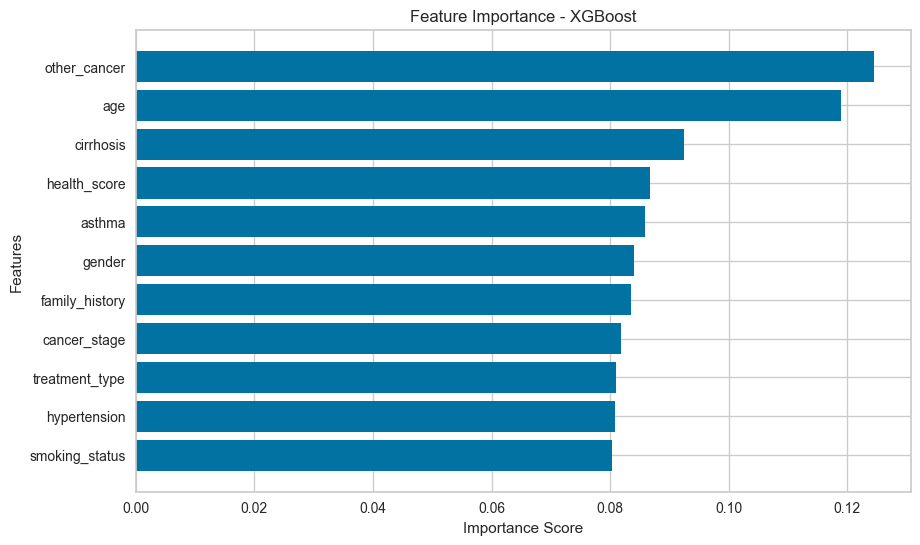

In [87]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_clf_xgb_bsp.best_estimator_.feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

# **Save Model**

In [90]:
import joblib

joblib.dump(best_model_xgb_bsp, "model_bsp_xgb.pkl")

['model_bsp_xgb.pkl']